**Import packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os
import scipy.ndimage as ndi
import PIL

from sklearn.metrics import balanced_accuracy_score

from IPython.display import display,HTML
from PIL import Image
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.optimizers import Adam

In [134]:
# Load cvs file with images information 
data = pd.read_csv('Original Data\\train_labels.csv')
data.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

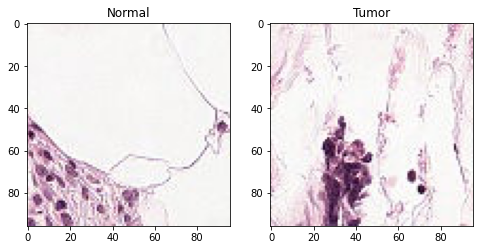

In [130]:
# plot two random image
plt.figure(figsize = (8,8))
norm = plt.imread('Original Data\\train\\f38a6374c348f90b587e046aac6079959adf3835.tif')
tum = plt.imread('Original Data\\train\\c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif')
plt.subplot(1,2,1)
plt.title('Normal')
plt.imshow(norm)
plt.subplot(1,2,2)
plt.title('Tumor')
plt.imshow(tum)
plt.show()

In [136]:
data.groupby('label').count()

id
label        
0      130908
1       89117

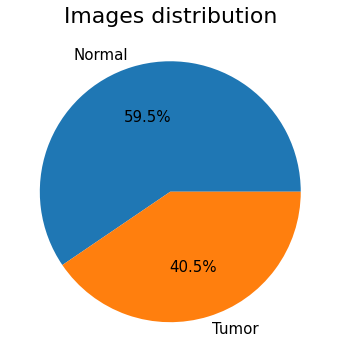

In [144]:
plt.figure(figsize =(6,6))
plt.pie(data.groupby('label')['label'].count(), labels= ['Normal', 'Tumor'], autopct = '%1.1f%%', textprops = {'fontsize':15})
plt.title('Images distribution', fontsize =22)
plt.show()

In [ ]:
# All images are in one directory: need to split in 2 folders, Test and Train, and separate them in Tumor and Normal
    
os.mkdir('C:\\Users\\Gianluca\\Hist Cancer\Sorted')
os.mkdir('C:\\Users\\Gianluca\\Hist Cancer\Sorted\Train')
os.mkdir('C:\\Users\\Gianluca\\Hist Cancer\Sorted\Train\Tumor')
os.mkdir('C:\\Users\\Gianluca\\Hist Cancer\Sorted\Train\\Normal')

os.mkdir('C:\\Users\\Gianluca\\Hist Cancer\Sorted\Test')
os.mkdir('C:\\Users\\Gianluca\\Hist Cancer\Sorted\Test\Tumor')
os.mkdir('C:\\Users\\Gianluca\\Hist Cancer\Sorted\Test\\Normal')



cut_off = 0.2
for i,j in zip(data.id, data.label):
    train_test = np.random.random()
    try: 
        if train_test < cut_off:
            if j ==0:
                shutil.copy('Original Data\\train\\'+i+'.tif', 'Sorted\\Test\\Normal\\'+i+'.tif')
            else:
                shutil.copy('Original Data\\train\\'+i+'.tif', 'Sorted\\Test\\Tumor\\'+i+'.tif')

        else:
            if j ==0:
                shutil.copy('Original Data\\train\\'+i+'.tif', 'Sorted\\Train\\Normal\\'+i+'.tif')
            else:
                shutil.copy('Original Data\\train\\'+i+'.tif', 'Sorted\\Train\\Tumor\\'+i+'.tif')
    except:
        print(j, 'can\'t be open')
            

# MODELING 

## Model1 

In [23]:
train = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test = ImageDataGenerator(rescale=1./255)

train_gen = train.flow_from_directory('Sorted\Train', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')
        
        
test_gen = test.flow_from_directory('Sorted\Test', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')


Found 175780 images belonging to 2 classes.
Found 44245 images belonging to 2 classes.


In [24]:
mm1 = Sequential()
mm1.add(Conv2D(96, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
mm1.add(Conv2D(48, (3,3), activation = 'relu', padding ='same'))
mm1.add(MaxPool2D((2,2)))
mm1.add(Conv2D(96, (3,3), activation = 'relu', padding ='same'))
mm1.add(Conv2D(48, (3,3), activation = 'relu',  padding ='same'))
mm1.add(MaxPool2D((2,2)))
mm1.add(Conv2D(48, (3,3), activation = 'relu',  padding ='same'))
mm1.add(MaxPool2D((2,2)))
mm1.add(Conv2D(48, (3,3), activation = 'relu',  padding ='same'))
mm1.add(Flatten())
mm1.add(Dense(375, activation = 'relu'))
mm1.add(Dropout(0.25))
mm1.add(Dense(375, activation = 'relu'))
mm1.add(Dense(1, activation = 'sigmoid'))
mm1.summary()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),]

opt1= Adam(lr= 0.001)
mm1.compile(optimizer = opt1, loss = 'binary_crossentropy', metrics = METRICS )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 96, 96, 96)        2688      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 48)        41520     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 48, 48, 48)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 96)        41568     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 48, 48, 48)        41520     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 24, 24, 48)       

In [25]:
res1 = mm1.fit_generator(train_gen, steps_per_epoch=550, max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 50 , validation_data=test_gen, validation_steps=139)

Epoch 1/50
550/550 [==============================] - 162s 294ms/step - loss: 0.4496 - tp: 48936.0000 - fp: 14287.0000 - tn: 90420.0000 - fn: 22137.0000 - accuracy: 0.7928 - precision: 0.7740 - recall: 0.6885 - auc: 0.8633 - val_loss: 0.3809 - val_tp: 9344.0000 - val_fp: 816.0000 - val_tn: 25620.0000 - val_fn: 8465.0000 - val_accuracy: 0.7902 - val_precision: 0.9197 - val_recall: 0.5247 - val_auc: 0.8885
Epoch 2/50
550/550 [==============================] - 163s 296ms/step - loss: 0.3447 - tp: 56552.0000 - fp: 11602.0000 - tn: 92997.0000 - fn: 14629.0000 - accuracy: 0.8508 - precision: 0.8298 - recall: 0.7945 - auc: 0.9226 - val_loss: 0.3430 - val_tp: 11766.0000 - val_fp: 648.0000 - val_tn: 25661.0000 - val_fn: 6170.0000 - val_accuracy: 0.8459 - val_precision: 0.9478 - val_recall: 0.6560 - val_auc: 0.9399
Epoch 3/50
550/550 [==============================] - 163s 296ms/step - loss: 0.2965 - tp: 58341.0000 - fp: 8965.0000 - tn: 95634.0000 - fn: 12840.0000 - accuracy: 0.8760 - precision:

550/550 [==============================] - 162s 295ms/step - loss: 0.1370 - tp: 65940.0000 - fp: 3654.0000 - tn: 100945.0000 - fn: 5241.0000 - accuracy: 0.9494 - precision: 0.9475 - recall: 0.9264 - auc: 0.9867 - val_loss: 0.1861 - val_tp: 16891.0000 - val_fp: 1212.0000 - val_tn: 25097.0000 - val_fn: 1045.0000 - val_accuracy: 0.9490 - val_precision: 0.9330 - val_recall: 0.9417 - val_auc: 0.9877
Epoch 42/50
550/550 [==============================] - 162s 294ms/step - loss: 0.1398 - tp: 65867.0000 - fp: 3742.0000 - tn: 100857.0000 - fn: 5314.0000 - accuracy: 0.9485 - precision: 0.9462 - recall: 0.9253 - auc: 0.9861 - val_loss: 0.1513 - val_tp: 16247.0000 - val_fp: 709.0000 - val_tn: 25600.0000 - val_fn: 1689.0000 - val_accuracy: 0.9458 - val_precision: 0.9582 - val_recall: 0.9058 - val_auc: 0.9859
Epoch 43/50
550/550 [==============================] - 163s 296ms/step - loss: 0.1364 - tp: 65983.0000 - fp: 3640.0000 - tn: 100959.0000 - fn: 5198.0000 - accuracy: 0.9497 - precision: 0.9477 -

In [28]:
#save model info
model1_his = pd.DataFrame(res1.history)
model1_his.to_csv('model1_his.csv')

model1_json = mm1.to_json()
with open('model1.json', 'w') as file1:
    file1.write(model1_json)
    
mm1.save_weights('model1_W.h5')

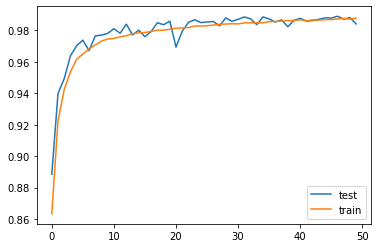

In [30]:
plt.plot(model1_his['val_auc'], label ='test')
plt.plot(model1_his['auc'], label ='train')
plt.legend()
plt.show()

## Model2 = like Model1 with more filters

In [3]:
train = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test = ImageDataGenerator(rescale=1./255)

train_gen = train.flow_from_directory('Sorted\Train', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')
        
        
test_gen = test.flow_from_directory('Sorted\Test', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')

Found 175780 images belonging to 2 classes.
Found 44245 images belonging to 2 classes.


In [32]:
mm2 = Sequential()
mm2.add(Conv2D(96, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
mm2.add(Conv2D(96, (3,3), activation = 'relu', padding ='same'))
mm2.add(MaxPool2D((2,2)))
mm2.add(Conv2D(96, (3,3), activation = 'relu', padding ='same'))
mm2.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm2.add(MaxPool2D((2,2)))
mm2.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm2.add(MaxPool2D((2,2)))
mm2.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm2.add(Flatten())
mm2.add(Dense(375, activation = 'relu'))
mm2.add(Dropout(0.25))
mm2.add(Dense(375, activation = 'relu'))
mm2.add(Dense(1, activation = 'sigmoid'))
mm2.summary()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),]

opt2= Adam(lr= 0.001)
mm2.compile(optimizer = opt2, loss = 'binary_crossentropy', metrics = METRICS )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 96, 96, 96)        2688      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 96, 96, 96)        83040     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 24, 24, 96)       

In [33]:
res2 = mm2.fit_generator(train_gen, steps_per_epoch=550, max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 50 , validation_data=test_gen, validation_steps=139)

Epoch 1/50
550/550 [==============================] - 204s 371ms/step - loss: 0.4721 - tp: 44788.0000 - fp: 13490.0000 - tn: 91084.0000 - fn: 26418.0000 - accuracy: 0.7730 - precision: 0.7685 - recall: 0.6290 - auc: 0.8475 - val_loss: 0.3959 - val_tp: 10064.0000 - val_fp: 982.0000 - val_tn: 25594.0000 - val_fn: 7605.0000 - val_accuracy: 0.8059 - val_precision: 0.9111 - val_recall: 0.5696 - val_auc: 0.9042
Epoch 2/50
550/550 [==============================] - 201s 366ms/step - loss: 0.3671 - tp: 55496.0000 - fp: 12414.0000 - tn: 92185.0000 - fn: 15685.0000 - accuracy: 0.8401 - precision: 0.8172 - recall: 0.7796 - auc: 0.9116 - val_loss: 0.5602 - val_tp: 9656.0000 - val_fp: 477.0000 - val_tn: 25832.0000 - val_fn: 8280.0000 - val_accuracy: 0.8021 - val_precision: 0.9529 - val_recall: 0.5384 - val_auc: 0.9284
Epoch 3/50
550/550 [==============================] - 201s 366ms/step - loss: 0.3180 - tp: 57557.0000 - fp: 10064.0000 - tn: 94535.0000 - fn: 13624.0000 - accuracy: 0.8652 - precision

550/550 [==============================] - 199s 362ms/step - loss: 0.1286 - tp: 66291.0000 - fp: 3382.0000 - tn: 101217.0000 - fn: 4890.0000 - accuracy: 0.9529 - precision: 0.9515 - recall: 0.9313 - auc: 0.9881 - val_loss: 0.1511 - val_tp: 15865.0000 - val_fp: 622.0000 - val_tn: 25687.0000 - val_fn: 2071.0000 - val_accuracy: 0.9391 - val_precision: 0.9623 - val_recall: 0.8845 - val_auc: 0.9833
Epoch 42/50
550/550 [==============================] - 199s 362ms/step - loss: 0.1293 - tp: 66214.0000 - fp: 3378.0000 - tn: 101221.0000 - fn: 4967.0000 - accuracy: 0.9525 - precision: 0.9515 - recall: 0.9302 - auc: 0.9879 - val_loss: 0.2350 - val_tp: 15617.0000 - val_fp: 418.0000 - val_tn: 25891.0000 - val_fn: 2319.0000 - val_accuracy: 0.9381 - val_precision: 0.9739 - val_recall: 0.8707 - val_auc: 0.9850
Epoch 43/50
550/550 [==============================] - 199s 361ms/step - loss: 0.1273 - tp: 66405.0000 - fp: 3375.0000 - tn: 101224.0000 - fn: 4776.0000 - accuracy: 0.9536 - precision: 0.9516 - 

In [34]:
#save model info
model2_his = pd.DataFrame(res2.history)
model2_his.to_csv('model2_his.csv')

model2_json = mm2.to_json()
with open('model2.json', 'w') as file2:
    file2.write(model2_json)
    
mm2.save_weights('model2_W.h5')

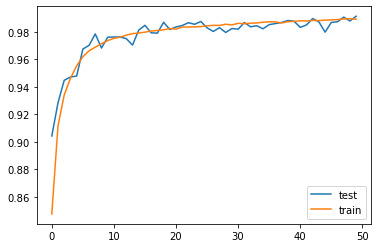

In [35]:
plt.plot(model2_his['val_auc'], label ='test')
plt.plot(model2_his['auc'], label ='train')
plt.legend()
plt.show()

## Model2B = like Model2 changed image generation params, more epochs

In [51]:
trainb = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.25,
        height_shift_range=0.25,
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='nearest')

testb = ImageDataGenerator(rescale=1./255)

train_genb = trainb.flow_from_directory('Sorted\Train', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')
        
        
test_genb = testb.flow_from_directory('Sorted\Test', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')

Found 175780 images belonging to 2 classes.
Found 44245 images belonging to 2 classes.


In [52]:
mm2b = Sequential()
mm2b.add(Conv2D(96, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
mm2b.add(Conv2D(96, (3,3), activation = 'relu', padding ='same'))
mm2b.add(MaxPool2D((2,2)))
mm2b.add(Conv2D(96, (3,3), activation = 'relu', padding ='same'))
mm2b.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm2b.add(MaxPool2D((2,2)))
mm2b.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm2b.add(MaxPool2D((2,2)))
mm2b.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm2b.add(Flatten())
mm2b.add(Dense(375, activation = 'relu'))
mm2b.add(Dropout(0.25))
mm2b.add(Dense(375, activation = 'relu'))
mm2b.add(Dense(1, activation = 'sigmoid'))
mm2b.summary()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),]

opt2b= Adam(lr= 0.001)
mm2b.compile(optimizer = opt2b, loss = 'binary_crossentropy', metrics = METRICS )

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 96, 96, 96)        2688      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 96, 96, 96)        83040     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 24, 24, 96)      

In [53]:
res2b = mm2b.fit_generator(train_genb, steps_per_epoch=550, max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 75 , validation_data=test_genb, validation_steps=139)

Epoch 1/75
550/550 [==============================] - 208s 378ms/step - loss: 0.4750 - tp: 45622.0000 - fp: 14130.0000 - tn: 90853.0000 - fn: 25175.0000 - accuracy: 0.7764 - precision: 0.7635 - recall: 0.6444 - auc: 0.8442 - val_loss: 0.4562 - val_tp: 9484.0000 - val_fp: 1199.0000 - val_tn: 25243.0000 - val_fn: 8319.0000 - val_accuracy: 0.7849 - val_precision: 0.8878 - val_recall: 0.5327 - val_auc: 0.8826
Epoch 2/75
550/550 [==============================] - 201s 365ms/step - loss: 0.3866 - tp: 53581.0000 - fp: 12481.0000 - tn: 92118.0000 - fn: 17600.0000 - accuracy: 0.8289 - precision: 0.8111 - recall: 0.7527 - auc: 0.9013 - val_loss: 0.2847 - val_tp: 10657.0000 - val_fp: 716.0000 - val_tn: 25593.0000 - val_fn: 7279.0000 - val_accuracy: 0.8193 - val_precision: 0.9370 - val_recall: 0.5942 - val_auc: 0.9244
Epoch 3/75
550/550 [==============================] - 201s 366ms/step - loss: 0.3301 - tp: 56497.0000 - fp: 10194.0000 - tn: 94405.0000 - fn: 14684.0000 - accuracy: 0.8585 - precisio

550/550 [==============================] - 200s 364ms/step - loss: 0.1457 - tp: 65631.0000 - fp: 3841.0000 - tn: 100758.0000 - fn: 5550.0000 - accuracy: 0.9466 - precision: 0.9447 - recall: 0.9220 - auc: 0.9850 - val_loss: 0.2826 - val_tp: 16353.0000 - val_fp: 862.0000 - val_tn: 25447.0000 - val_fn: 1583.0000 - val_accuracy: 0.9447 - val_precision: 0.9499 - val_recall: 0.9117 - val_auc: 0.9859
Epoch 42/75
550/550 [==============================] - 200s 364ms/step - loss: 0.1470 - tp: 65526.0000 - fp: 3950.0000 - tn: 100649.0000 - fn: 5655.0000 - accuracy: 0.9454 - precision: 0.9431 - recall: 0.9206 - auc: 0.9847 - val_loss: 0.1813 - val_tp: 14941.0000 - val_fp: 308.0000 - val_tn: 26001.0000 - val_fn: 2995.0000 - val_accuracy: 0.9253 - val_precision: 0.9798 - val_recall: 0.8330 - val_auc: 0.9839
Epoch 43/75
550/550 [==============================] - 200s 364ms/step - loss: 0.1455 - tp: 65596.0000 - fp: 3830.0000 - tn: 100769.0000 - fn: 5585.0000 - accuracy: 0.9464 - precision: 0.9448 - 

In [54]:
#save model info
model2b_his = pd.DataFrame(res2b.history)
model2b_his.to_csv('model2b_his.csv')

model2b_json = mm2b.to_json()
with open('model2b.json', 'w') as file2b:
    file2b.write(model2b_json)
    
mm2b.save_weights('model2b_W.h5')

In [84]:
im = plt.imread('Original Data\\train\\dccb762cf82a9c2c2ed4e712e213d70408271d4d.tif')
im2 = im.reshape(1,96,96,3) / 255
pred = mm2b.predict(im2)
pred

array([[0.04566692]], dtype=float32)

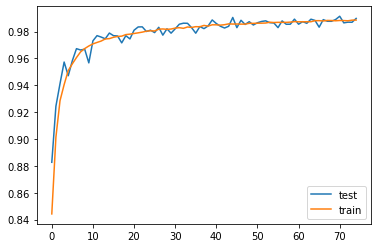

In [55]:
plt.plot(model2b_his['val_auc'], label ='test')
plt.plot(model2b_his['auc'], label ='train')
plt.legend()
plt.show()

## Model3  = like Model2 with more filters

In [4]:
train = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test = ImageDataGenerator(rescale=1./255)

train_gen = train.flow_from_directory('Sorted\Train', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')
        
        
test_gen = test.flow_from_directory('Sorted\Test', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')

Found 175780 images belonging to 2 classes.
Found 44245 images belonging to 2 classes.


In [5]:
mm3 = Sequential()
mm3.add(Conv2D(128, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
mm3.add(Conv2D(128, (3,3), activation = 'relu', padding ='same'))
mm3.add(MaxPool2D((2,2)))
mm3.add(Conv2D(128, (3,3), activation = 'relu', padding ='same'))
mm3.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
mm3.add(MaxPool2D((2,2)))
mm3.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
mm3.add(MaxPool2D((2,2)))
mm3.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm3.add(Flatten())
mm3.add(Dense(375, activation = 'relu'))
mm3.add(Dropout(0.25))
mm3.add(Dense(375, activation = 'relu'))
mm3.add(Dense(1, activation = 'sigmoid'))
mm3.summary()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),]

opt3= Adam(lr= 0.001)
mm3.compile(optimizer = opt3, loss = 'binary_crossentropy', metrics = METRICS )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 128)       3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)     

In [6]:
res3 = mm3.fit_generator(train_gen, steps_per_epoch=550, max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 50 , validation_data=test_gen, validation_steps=139)


Epoch 1/50
550/550 [==============================] - 274s 498ms/step - loss: 0.4838 - tp: 43270.0000 - fp: 13279.0000 - tn: 91597.0000 - fn: 27634.0000 - accuracy: 0.7672 - precision: 0.7652 - recall: 0.6103 - auc: 0.8374 - val_loss: 0.4448 - val_tp: 10622.0000 - val_fp: 1285.0000 - val_tn: 25039.0000 - val_fn: 7299.0000 - val_accuracy: 0.8060 - val_precision: 0.8921 - val_recall: 0.5927 - val_auc: 0.8981
Epoch 2/50
550/550 [==============================] - 259s 471ms/step - loss: 0.3875 - tp: 54507.0000 - fp: 13314.0000 - tn: 91285.0000 - fn: 16674.0000 - accuracy: 0.8294 - precision: 0.8037 - recall: 0.7658 - auc: 0.9019 - val_loss: 0.4036 - val_tp: 10984.0000 - val_fp: 1107.0000 - val_tn: 25202.0000 - val_fn: 6952.0000 - val_accuracy: 0.8179 - val_precision: 0.9084 - val_recall: 0.6124 - val_auc: 0.9176
Epoch 3/50
550/550 [==============================] - 260s 473ms/step - loss: 0.3309 - tp: 56869.0000 - fp: 10667.0000 - tn: 93932.0000 - fn: 14312.0000 - accuracy: 0.8579 - preci

550/550 [==============================] - 257s 467ms/step - loss: 0.1272 - tp: 66411.0000 - fp: 3460.0000 - tn: 101139.0000 - fn: 4770.0000 - accuracy: 0.9532 - precision: 0.9505 - recall: 0.9330 - auc: 0.9885 - val_loss: 0.1916 - val_tp: 16645.0000 - val_fp: 830.0000 - val_tn: 25479.0000 - val_fn: 1291.0000 - val_accuracy: 0.9521 - val_precision: 0.9525 - val_recall: 0.9280 - val_auc: 0.9887
Epoch 41/50
550/550 [==============================] - 257s 467ms/step - loss: 0.1240 - tp: 66511.0000 - fp: 3280.0000 - tn: 101319.0000 - fn: 4670.0000 - accuracy: 0.9548 - precision: 0.9530 - recall: 0.9344 - auc: 0.9889 - val_loss: 0.1423 - val_tp: 16055.0000 - val_fp: 413.0000 - val_tn: 25896.0000 - val_fn: 1881.0000 - val_accuracy: 0.9482 - val_precision: 0.9749 - val_recall: 0.8951 - val_auc: 0.9883
Epoch 42/50
550/550 [==============================] - 257s 467ms/step - loss: 0.1245 - tp: 66535.0000 - fp: 3290.0000 - tn: 101309.0000 - fn: 4646.0000 - accuracy: 0.9549 - precision: 0.9529 - 

In [9]:
#save model info
model3_his = pd.DataFrame(res3.history)
model3_his.to_csv('model3_his.csv')

model3_json = mm3.to_json()
with open('model3.json', 'w') as file3:
    file3.write(model3_json)
    
mm3.save_weights('model3_W.h5')

[]

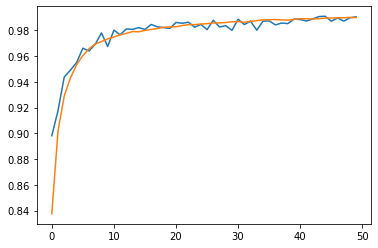

In [10]:
plt.plot(model3_his['val_auc'], label ='test')
plt.plot(model3_his['auc'], label ='train')
plt.plot()

## Model4 = like Model1 less filters

In [11]:
train = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test = ImageDataGenerator(rescale=1./255)

train_gen = train.flow_from_directory('Sorted\Train', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')
        
        
test_gen = test.flow_from_directory('Sorted\Test', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')

Found 175780 images belonging to 2 classes.
Found 44245 images belonging to 2 classes.


In [12]:
mm4 = Sequential()
mm4.add(Conv2D(96, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
mm4.add(MaxPool2D((2,2)))
mm4.add(Conv2D(96, (3,3), activation = 'relu', padding ='same'))
mm4.add(MaxPool2D((2,2)))
mm4.add(Conv2D(48, (3,3), activation = 'relu',  padding ='same'))
mm4.add(MaxPool2D((2,2)))
mm4.add(Conv2D(48, (3,3), activation = 'relu',  padding ='same'))
mm4.add(Flatten())
mm4.add(Dense(375, activation = 'relu'))
mm4.add(Dropout(0.25))
mm4.add(Dense(375, activation = 'relu'))
mm4.add(Dense(1, activation = 'sigmoid'))
mm4.summary()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

opt4= Adam(lr= 0.001)
mm4.compile(optimizer = opt4, loss = 'binary_crossentropy', metrics = METRICS )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 96, 96, 96)        2688      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 96)        83040     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 48)        41520     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 48)       

In [13]:
res4 = mm4.fit_generator(train_gen, steps_per_epoch=550, max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 50 , validation_data=test_gen, validation_steps=139)

Epoch 1/50
550/550 [==============================] - 162s 295ms/step - loss: 0.4678 - tp: 46432.0000 - fp: 14230.0000 - tn: 90017.0000 - fn: 25101.0000 - accuracy: 0.7762 - precision: 0.7654 - recall: 0.6491 - auc: 0.8503 - val_loss: 0.5981 - val_tp: 7769.0000 - val_fp: 480.0000 - val_tn: 25928.0000 - val_fn: 10068.0000 - val_accuracy: 0.7616 - val_precision: 0.9418 - val_recall: 0.4356 - val_auc: 0.8631
Epoch 2/50
550/550 [==============================] - 159s 289ms/step - loss: 0.3689 - tp: 55418.0000 - fp: 12500.0000 - tn: 92099.0000 - fn: 15763.0000 - accuracy: 0.8392 - precision: 0.8160 - recall: 0.7786 - auc: 0.9110 - val_loss: 0.4792 - val_tp: 11314.0000 - val_fp: 851.0000 - val_tn: 25458.0000 - val_fn: 6622.0000 - val_accuracy: 0.8311 - val_precision: 0.9300 - val_recall: 0.6308 - val_auc: 0.9272
Epoch 3/50
550/550 [==============================] - 159s 289ms/step - loss: 0.3395 - tp: 56421.0000 - fp: 10852.0000 - tn: 93747.0000 - fn: 14760.0000 - accuracy: 0.8543 - precisio

550/550 [==============================] - 158s 287ms/step - loss: 0.1705 - tp: 64493.0000 - fp: 4716.0000 - tn: 99883.0000 - fn: 6688.0000 - accuracy: 0.9351 - precision: 0.9319 - recall: 0.9060 - auc: 0.9799 - val_loss: 0.3230 - val_tp: 13077.0000 - val_fp: 421.0000 - val_tn: 25888.0000 - val_fn: 4859.0000 - val_accuracy: 0.8807 - val_precision: 0.9688 - val_recall: 0.7291 - val_auc: 0.9622
Epoch 42/50
550/550 [==============================] - 158s 287ms/step - loss: 0.1675 - tp: 64603.0000 - fp: 4535.0000 - tn: 100064.0000 - fn: 6578.0000 - accuracy: 0.9368 - precision: 0.9344 - recall: 0.9076 - auc: 0.9807 - val_loss: 0.1607 - val_tp: 13820.0000 - val_fp: 593.0000 - val_tn: 25716.0000 - val_fn: 4116.0000 - val_accuracy: 0.8936 - val_precision: 0.9589 - val_recall: 0.7705 - val_auc: 0.9679
Epoch 43/50
550/550 [==============================] - 158s 287ms/step - loss: 0.1694 - tp: 64556.0000 - fp: 4789.0000 - tn: 99810.0000 - fn: 6625.0000 - accuracy: 0.9351 - precision: 0.9309 - re

In [14]:
#save model info
model4_his = pd.DataFrame(res4.history)
model4_his.to_csv('model4_his.csv')

model4_json = mm4.to_json()
with open('model4.json', 'w') as file4:
    file4.write(model4_json)
    
mm4.save_weights('model4_W.h5')

[]

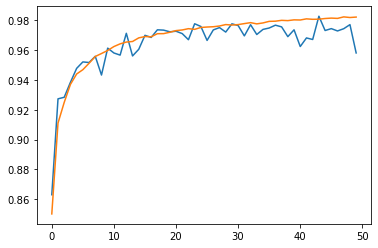

In [15]:
plt.plot(model4_his['val_auc'], label ='test')
plt.plot(model4_his['auc'], label ='train')
plt.show()

## Model 5 = like Model3 with less layers

In [27]:
train = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test = ImageDataGenerator(rescale=1./255)

train_gen = train.flow_from_directory('Sorted\Train', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')
        
        
test_gen = test.flow_from_directory('Sorted\Test', shuffle = True, target_size=(96, 96), batch_size=320, class_mode='binary')

Found 175780 images belonging to 2 classes.
Found 44245 images belonging to 2 classes.


In [28]:
mm5 = Sequential()
mm5.add(Conv2D(128, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
mm5.add(MaxPool2D((2,2)))
mm5.add(Conv2D(128, (3,3), activation = 'relu', padding ='same'))
mm5.add(MaxPool2D((2,2)))
mm5.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
mm5.add(MaxPool2D((2,2)))
mm5.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
mm5.add(Flatten())
mm5.add(Dense(375, activation = 'relu'))
mm5.add(Dropout(0.25))
mm5.add(Dense(375, activation = 'relu'))
mm5.add(Dense(1, activation = 'sigmoid'))
mm5.summary()

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

opt5= Adam(lr= 0.001)
mm5.compile(optimizer = opt5, loss = 'binary_crossentropy', metrics = METRICS )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 96, 96, 128)       3584      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 96)       

In [29]:
res5 = mm5.fit_generator(train_gen, steps_per_epoch=550, max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 50 , validation_data=test_gen, validation_steps=139)

Epoch 1/50
550/550 [==============================] - 191s 347ms/step - loss: 0.4666 - tp: 46014.0000 - fp: 13676.0000 - tn: 91315.0000 - fn: 24775.0000 - accuracy: 0.7813 - precision: 0.7709 - recall: 0.6500 - auc: 0.8512 - val_loss: 0.5415 - val_tp: 7526.0000 - val_fp: 624.0000 - val_tn: 25685.0000 - val_fn: 10410.0000 - val_accuracy: 0.7506 - val_precision: 0.9234 - val_recall: 0.4196 - val_auc: 0.8659
Epoch 2/50
550/550 [==============================] - 158s 288ms/step - loss: 0.3694 - tp: 54727.0000 - fp: 12120.0000 - tn: 92479.0000 - fn: 16454.0000 - accuracy: 0.8374 - precision: 0.8187 - recall: 0.7688 - auc: 0.9106 - val_loss: 0.7560 - val_tp: 5987.0000 - val_fp: 403.0000 - val_tn: 25906.0000 - val_fn: 11949.0000 - val_accuracy: 0.7208 - val_precision: 0.9369 - val_recall: 0.3338 - val_auc: 0.8729
Epoch 3/50
550/550 [==============================] - 159s 288ms/step - loss: 0.3294 - tp: 56618.0000 - fp: 10386.0000 - tn: 94213.0000 - fn: 14563.0000 - accuracy: 0.8581 - precisio

550/550 [==============================] - 159s 289ms/step - loss: 0.1476 - tp: 65540.0000 - fp: 3986.0000 - tn: 100613.0000 - fn: 5641.0000 - accuracy: 0.9452 - precision: 0.9427 - recall: 0.9208 - auc: 0.9847 - val_loss: 0.1231 - val_tp: 15392.0000 - val_fp: 522.0000 - val_tn: 25787.0000 - val_fn: 2544.0000 - val_accuracy: 0.9307 - val_precision: 0.9672 - val_recall: 0.8582 - val_auc: 0.9817
Epoch 42/50
550/550 [==============================] - 159s 288ms/step - loss: 0.1470 - tp: 65524.0000 - fp: 3999.0000 - tn: 100600.0000 - fn: 5657.0000 - accuracy: 0.9451 - precision: 0.9425 - recall: 0.9205 - auc: 0.9848 - val_loss: 0.0973 - val_tp: 15353.0000 - val_fp: 565.0000 - val_tn: 25744.0000 - val_fn: 2583.0000 - val_accuracy: 0.9289 - val_precision: 0.9645 - val_recall: 0.8560 - val_auc: 0.9794
Epoch 43/50
550/550 [==============================] - 159s 289ms/step - loss: 0.1464 - tp: 65526.0000 - fp: 3986.0000 - tn: 100613.0000 - fn: 5655.0000 - accuracy: 0.9452 - precision: 0.9427 - 

In [30]:
#save model info
model5_his = pd.DataFrame(res5.history)
model5_his.to_csv('model5_his.csv')

model5_json = mm5.to_json()
with open('model5.json', 'w') as file5:
    file5.write(model5_json)
    
mm5.save_weights('model5_W.h5')

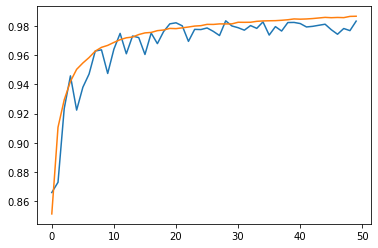

In [31]:
plt.plot(model5_his['val_auc'], label ='test')
plt.plot(model5_his['auc'], label ='train')
plt.show()

# K FOLD VALIDATION APPROACH 

In [ ]:
# need to create 2 dataframe one for train and one for test, split data in train (for K_fold) and Test(the validaton set) 
# Tumor and Normal images are not separated.

In [3]:
data = pd.read_csv('Original Data\\train_labels.csv')
data.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [4]:
# split all images in TRAIN/TEST sets and create a DFs holding their info

cut_off = 0.2
Test_data = pd.DataFrame(columns=['id', 'label'])
Train_data =pd.DataFrame(columns=['id', 'label'])

for i,j in zip(data.id, data.label):
    train_test = np.random.random()
    try: 
        if train_test <= cut_off:
            shutil.copy('Original Data\\train\\'+i+'.tif', 'K-fold\\Test\\'+i+'.tif')
            Test_data = Test_data.append(data[data['id']==i])
        else:
            Train_data = Train_data.append(data[data['id']==i])
            shutil.copy('Original Data\\train\\'+i+'.tif', 'K-fold\\Train\\'+i+'.tif')

    except:
        print(i, 'can\'t be open')

In [13]:
#add .tif to id 

def add_ext(x):
    return x+'.tif'

#Test_data['id'] = Test_data['id'].apply(lambda x: add_ext(x))
#Train_data['id'] = Train_data['id'].apply(lambda x: add_ext(x))

Test_data.head()

id label
9   8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0
10  a106469bbfda4cdc5a9da7ac0152927bf1b4a92d.tif     0
16  a1c001f6b242c72d3066f15ac6eb059ea72d30ba.tif     0
21  5fc468030b7fdb5a0b656a45fa0dde5553dd9064.tif     0
22  4e1e69b64cdeb757178fc5b657b4e5ea07e53935.tif     0

In [14]:
# Save DFs
'''Test_data.to_csv('Test_data.csv')
Train_data.to_csv('Train_data.csv')'''

In [131]:
# import data 
Test_data = pd.read_csv('Test_data.csv').drop('Unnamed: 0', axis =1)
Train_data= pd.read_csv('Train_data.csv').drop('Unnamed: 0', axis =1)


### 5 Folds, 75 epochs, lr decreasing at 50 epochs

In [325]:
idg = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.25,
        height_shift_range=0.25,
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest')


Train_data['label']= Train_data['label'].astype(str)
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
Y = Train_data['label']
n = len(Y)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Train'

from keras.callbacks import LearningRateScheduler
def decre( epochs, lr):
    if epochs < 50:
        return lr
    else:
        return lr*0.90

cb = LearningRateScheduler(decre)
  
fold_var = 1 
for train_index, val_index in kf.split(np.zeros(n),Y):
    training_data = Train_data.iloc[train_index]
    test_data = Train_data.iloc[val_index] 
    
    train_data_gen = idg.flow_from_dataframe(training_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size= 240)
    test_data_gen = idg.flow_from_dataframe(test_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size= 240 )
    
    model = Sequential()
    model.add(Conv2D(128, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding ='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding ='same'))
    model.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
    model.add(Flatten())
    model.add(Dense(375, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(375, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()

    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),]

    opt = Adam(lr= 0.001)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = METRICS)
    
    result = model.fit_generator(train_data_gen, steps_per_epoch=587   ,  callbacks= [cb], max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 75, validation_data = test_data_gen,  validation_steps = 147)
    
    model_name  = 'Model_K_fold_Second_strategy'+ str(fold_var)
    mod = model.to_json()
    
    with open(model_name + ".json", "w") as file:
        file.write(mod)
    
    model.save_weights(model_name + ".h5")

    history_data = pd.DataFrame(result.history)
    history_data.to_csv('Model_K_fold_Second_strategy_'+ str(fold_var)+'.csv')
    

    fold_var +=1

Found 140720 validated image filenames belonging to 2 classes.
Found 35180 validated image filenames belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 96, 96, 128)       3584      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 128)       147584    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 128)       0     

Epoch 15/75
587/587 [==============================] - 217s 369ms/step - loss: 0.6750 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83734.0000 - fn: 56986.0000 - accuracy: 0.5950 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4979 - val_loss: 0.6605 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 21011.0000 - val_fn: 14169.0000 - val_accuracy: 0.5972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 16/75
587/587 [==============================] - 216s 369ms/step - loss: 0.6751 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83734.0000 - fn: 56986.0000 - accuracy: 0.5950 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4976 - val_loss: 0.6730 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 21011.0000 - val_fn: 14169.0000 - val_accuracy: 0.5972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 17/75
587/587 [==============================] - 217s 370ms/step - loss: 0.6751 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83734.0000 - fn:

587/587 [==============================] - 217s 369ms/step - loss: 0.6750 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83734.0000 - fn: 56986.0000 - accuracy: 0.5950 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5007 - val_loss: 0.6485 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 21011.0000 - val_fn: 14169.0000 - val_accuracy: 0.5972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 54/75
587/587 [==============================] - 217s 369ms/step - loss: 0.6749 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83734.0000 - fn: 56986.0000 - accuracy: 0.5950 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5022 - val_loss: 0.6893 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 21011.0000 - val_fn: 14169.0000 - val_accuracy: 0.5972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 55/75
587/587 [==============================] - 216s 369ms/step - loss: 0.6750 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83734.0000 - fn: 56986.0000 

587/587 [==============================] - 218s 372ms/step - loss: 0.2058 - tp: 50284.0000 - fp: 4469.0000 - tn: 79299.0000 - fn: 6668.0000 - accuracy: 0.9209 - precision: 0.9184 - recall: 0.8829 - auc: 0.9709 - val_loss: 0.2207 - val_tp: 12553.0000 - val_fp: 1092.0000 - val_tn: 19885.0000 - val_fn: 1650.0000 - val_accuracy: 0.9221 - val_precision: 0.9200 - val_recall: 0.8838 - val_auc: 0.9711
Epoch 12/75
587/587 [==============================] - 218s 372ms/step - loss: 0.2032 - tp: 50342.0000 - fp: 4329.0000 - tn: 79439.0000 - fn: 6610.0000 - accuracy: 0.9223 - precision: 0.9208 - recall: 0.8839 - auc: 0.9715 - val_loss: 0.2073 - val_tp: 12876.0000 - val_fp: 1291.0000 - val_tn: 19686.0000 - val_fn: 1327.0000 - val_accuracy: 0.9256 - val_precision: 0.9089 - val_recall: 0.9066 - val_auc: 0.9751
Epoch 13/75
587/587 [==============================] - 218s 372ms/step - loss: 0.1979 - tp: 50522.0000 - fp: 4231.0000 - tn: 79537.0000 - fn: 6430.0000 - accuracy: 0.9242 - precision: 0.9227 - r

587/587 [==============================] - 218s 371ms/step - loss: 0.1383 - tp: 52899.0000 - fp: 2989.0000 - tn: 80779.0000 - fn: 4053.0000 - accuracy: 0.9500 - precision: 0.9465 - recall: 0.9288 - auc: 0.9866 - val_loss: 0.1757 - val_tp: 13427.0000 - val_fp: 1229.0000 - val_tn: 19748.0000 - val_fn: 776.0000 - val_accuracy: 0.9430 - val_precision: 0.9161 - val_recall: 0.9454 - val_auc: 0.9858
Epoch 52/75
587/587 [==============================] - 218s 371ms/step - loss: 0.1283 - tp: 53126.0000 - fp: 2751.0000 - tn: 81017.0000 - fn: 3826.0000 - accuracy: 0.9533 - precision: 0.9508 - recall: 0.9328 - auc: 0.9881 - val_loss: 0.2058 - val_tp: 13517.0000 - val_fp: 1180.0000 - val_tn: 19797.0000 - val_fn: 686.0000 - val_accuracy: 0.9470 - val_precision: 0.9197 - val_recall: 0.9517 - val_auc: 0.9880
Epoch 53/75
587/587 [==============================] - 218s 371ms/step - loss: 0.1287 - tp: 53031.0000 - fp: 2749.0000 - tn: 81019.0000 - fn: 3921.0000 - accuracy: 0.9526 - precision: 0.9507 - rec

587/587 [==============================] - 218s 372ms/step - loss: 0.2242 - tp: 49453.0000 - fp: 4837.0000 - tn: 78940.0000 - fn: 7490.0000 - accuracy: 0.9124 - precision: 0.9109 - recall: 0.8685 - auc: 0.9658 - val_loss: 0.1607 - val_tp: 12497.0000 - val_fp: 1033.0000 - val_tn: 19935.0000 - val_fn: 1715.0000 - val_accuracy: 0.9219 - val_precision: 0.9237 - val_recall: 0.8793 - val_auc: 0.9705
Epoch 11/75
587/587 [==============================] - 218s 372ms/step - loss: 0.2192 - tp: 49644.0000 - fp: 4801.0000 - tn: 78976.0000 - fn: 7299.0000 - accuracy: 0.9140 - precision: 0.9118 - recall: 0.8718 - auc: 0.9674 - val_loss: 0.2550 - val_tp: 12234.0000 - val_fp: 825.0000 - val_tn: 20143.0000 - val_fn: 1978.0000 - val_accuracy: 0.9203 - val_precision: 0.9368 - val_recall: 0.8608 - val_auc: 0.9710
Epoch 12/75
587/587 [==============================] - 218s 372ms/step - loss: 0.2079 - tp: 50168.0000 - fp: 4621.0000 - tn: 79156.0000 - fn: 6775.0000 - accuracy: 0.9190 - precision: 0.9157 - re

587/587 [==============================] - 219s 372ms/step - loss: 0.1409 - tp: 52575.0000 - fp: 2975.0000 - tn: 80802.0000 - fn: 4368.0000 - accuracy: 0.9478 - precision: 0.9464 - recall: 0.9233 - auc: 0.9859 - val_loss: 0.1091 - val_tp: 13295.0000 - val_fp: 888.0000 - val_tn: 20080.0000 - val_fn: 917.0000 - val_accuracy: 0.9487 - val_precision: 0.9374 - val_recall: 0.9355 - val_auc: 0.9866
Epoch 51/75
587/587 [==============================] - 218s 372ms/step - loss: 0.1328 - tp: 52898.0000 - fp: 2779.0000 - tn: 80998.0000 - fn: 4045.0000 - accuracy: 0.9515 - precision: 0.9501 - recall: 0.9290 - auc: 0.9873 - val_loss: 0.1452 - val_tp: 13231.0000 - val_fp: 729.0000 - val_tn: 20239.0000 - val_fn: 981.0000 - val_accuracy: 0.9514 - val_precision: 0.9478 - val_recall: 0.9310 - val_auc: 0.9867
Epoch 52/75
587/587 [==============================] - 218s 372ms/step - loss: 0.1302 - tp: 53010.0000 - fp: 2814.0000 - tn: 80963.0000 - fn: 3933.0000 - accuracy: 0.9521 - precision: 0.9496 - recal

587/587 [==============================] - 218s 372ms/step - loss: 0.2348 - tp: 48971.0000 - fp: 5218.0000 - tn: 78738.0000 - fn: 7793.0000 - accuracy: 0.9075 - precision: 0.9037 - recall: 0.8627 - auc: 0.9628 - val_loss: 0.2287 - val_tp: 12561.0000 - val_fp: 1443.0000 - val_tn: 19346.0000 - val_fn: 1830.0000 - val_accuracy: 0.9070 - val_precision: 0.8970 - val_recall: 0.8728 - val_auc: 0.9643
Epoch 10/75
587/587 [==============================] - 218s 372ms/step - loss: 0.2257 - tp: 49209.0000 - fp: 4905.0000 - tn: 79051.0000 - fn: 7555.0000 - accuracy: 0.9115 - precision: 0.9094 - recall: 0.8669 - auc: 0.9655 - val_loss: 0.2759 - val_tp: 13078.0000 - val_fp: 1559.0000 - val_tn: 19230.0000 - val_fn: 1313.0000 - val_accuracy: 0.9184 - val_precision: 0.8935 - val_recall: 0.9088 - val_auc: 0.9718
Epoch 11/75
587/587 [==============================] - 218s 372ms/step - loss: 0.2202 - tp: 49451.0000 - fp: 4919.0000 - tn: 79037.0000 - fn: 7313.0000 - accuracy: 0.9131 - precision: 0.9095 - r

587/587 [==============================] - 219s 373ms/step - loss: 0.1408 - tp: 52449.0000 - fp: 2959.0000 - tn: 80997.0000 - fn: 4315.0000 - accuracy: 0.9483 - precision: 0.9466 - recall: 0.9240 - auc: 0.9859 - val_loss: 0.1334 - val_tp: 13341.0000 - val_fp: 714.0000 - val_tn: 20075.0000 - val_fn: 1050.0000 - val_accuracy: 0.9499 - val_precision: 0.9492 - val_recall: 0.9270 - val_auc: 0.9871
Epoch 50/75
587/587 [==============================] - 219s 373ms/step - loss: 0.1392 - tp: 52428.0000 - fp: 2918.0000 - tn: 81038.0000 - fn: 4336.0000 - accuracy: 0.9485 - precision: 0.9473 - recall: 0.9236 - auc: 0.9862 - val_loss: 0.1456 - val_tp: 13049.0000 - val_fp: 514.0000 - val_tn: 20275.0000 - val_fn: 1342.0000 - val_accuracy: 0.9472 - val_precision: 0.9621 - val_recall: 0.9067 - val_auc: 0.9864
Epoch 51/75
587/587 [==============================] - 219s 373ms/step - loss: 0.1352 - tp: 52586.0000 - fp: 2811.0000 - tn: 81145.0000 - fn: 4178.0000 - accuracy: 0.9503 - precision: 0.9493 - rec

KeyboardInterrupt: 

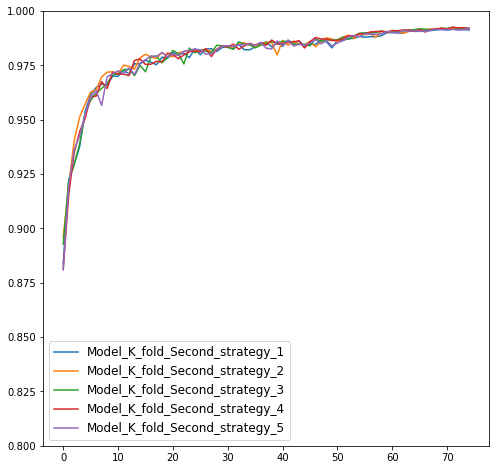

In [334]:
plt.figure(figsize =(8,8))
for i in range(1,6):
    data = pd.read_csv('Model_K_fold_Second_strategy_'+str(i)+'.csv')
    plt.plot(data['val_auc'], label = 'Model_K_fold_Second_strategy_'+str(i) )
plt.ylim([0.8,1])
plt.legend(prop ={'size': 12})          
plt.show()    


**Check the classification power on the validation set**

In [103]:

Test_data_second_strategy = pd.read_csv('Test_data.csv').drop('Unnamed: 0', axis =1)


idg_Test = ImageDataGenerator(rescale=1./255)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Test'

training_data = Test_data_second_strategy
training_data['label'] = training_data['label'].astype(str)

for i in range(1,6):

    with open('Model_K_fold_Second_strategy'+str(i)+'.json', 'r') as json_file:
        model= json_file.read()

    model = model_from_json(model) 
    model.load_weights('Model_K_fold_Second_strategy'+str(i)+'.h5')
    
    evaluation  = idg_Test.flow_from_dataframe(training_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = False, target_size=(96, 96), batch_size=240)
    
    results  = model.predict_generator(evaluation, steps = 184)
    Test_data_second_strategy['pred_KF'+str(i)+'_75epochs_p'] = results

Test_data_second_strategy

Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.


id label  \
0      8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0   
1      a106469bbfda4cdc5a9da7ac0152927bf1b4a92d.tif     0   
2      a1c001f6b242c72d3066f15ac6eb059ea72d30ba.tif     0   
3      5fc468030b7fdb5a0b656a45fa0dde5553dd9064.tif     0   
4      4e1e69b64cdeb757178fc5b657b4e5ea07e53935.tif     0   
...                                             ...   ...   
44120  5ba0f128323a89de471938df2ed33d7392a79b03.tif     0   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   
44122  9c0ad1bf43e2fa5e25fac5c8af616c5ae194c187.tif     0   
44123  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif     0   
44124  f129691c13433f66e1e0671ff1fe80944816f5a2.tif     0   

       pred_KF1_75epochs_p  pred_KF2_75epochs_p  pred_KF3_75epochs_p  \
0                 0.006126             0.033448             0.029508   
1                 0.001793             0.005494             0.001674   
2                 0.058916             0.038447             0.106363   
3                 0.000023             0.000782             0.000164   
4                 0.017487             0.028712             0.001856   
...                    ...                  ...                  ...   
44120             0.130902             0.671635             0.338447   
44121             0.270364             0.946603             0.510005   
44122             0.001324             0.000655             0.004051   
44123             0.263975             0.676696             0.018497   
44124             0.044646             0.008228             0.003385   

       pred_KF4_75epochs_p  pred_KF5_75epochs_p  
0                 0.000537             0.016902  
1                 0.000165             0.003200  
2                 0.037119             0.129210  
3                 0.000005             0.000699  
4                 0.003165             0.000918  
...                    ...                  ...  
44120             0.000412             0.411913  
44121             0.670303             0.259289  
44122             0.000255             0.001096  
44123             0.022248             0.078435  
44124             0.011667             0.035791  

[44125 rows x 7 columns]

In [104]:
Test_data_second_strategy['AVG_KF_75_epochs'] = Test_data_second_strategy[['pred_KF1_75epochs_p', 'pred_KF2_75epochs_p','pred_KF3_75epochs_p','pred_KF4_75epochs_p','pred_KF5_75epochs_p']].mean(axis =1)

# find best threshold

thresh_second = []
acc_second = []
for i in range(40):
    p = i/40
    thresh_second.append(p)
    pred = Test_data_second_strategy['AVG_KF_75_epochs'].apply(lambda x : np.where(x > p, 1, 0))
    acc_second.append(balanced_accuracy_score(Test_data_second_strategy['label'].astype(int), pred.astype(int), adjusted = True))

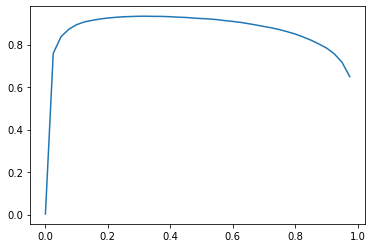

In [105]:
plt.plot(thresh_second, acc_second )
plt.show()

In [106]:
print('max accuracy is' , max(acc_second))
print('best threshold is', thresh_second[np.argmax(acc_second)])

max accuracy is 0.9334052050913091
best threshold is 0.325


In [107]:
Test_data_second_strategy['KF_75_epochs_final pred'] = Test_data_second_strategy['AVG_KF_75_epochs'].apply(lambda x : np.where(x > 0.325, 1, 0))
wrong_final = Test_data_second_strategy[Test_data_second_strategy['KF_75_epochs_final pred'] !=Test_data_second_strategy['label'].astype(int)]
wrong_final

id label  \
10     22161191ffa34fd9a14f07d1bd55a1fea3a899b6.tif     0   
41     b11d38879a191ae46e5faa3bc38280a1c353fff3.tif     1   
44     c462665961659b9b15af0fdab61c7725bfe7a37e.tif     1   
84     0e3676c7d2df7b6e1dab47a3d63061c845e2895f.tif     1   
88     b32740eda86d2730be229e0330c9f57250bebd9e.tif     1   
...                                             ...   ...   
44055  c84976300e21f882559f391faed50539736634fb.tif     1   
44063  240b3973e336e4b082f2d5a28574dc6b1bd671be.tif     1   
44078  aed33920dac44b9cc403939d880fe66922e4038e.tif     1   
44086  e5a7924f061b50df518a260d8d508790f68327eb.tif     0   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   

       pred_KF1_75epochs_p  pred_KF2_75epochs_p  pred_KF3_75epochs_p  \
10                0.374386             0.209634             0.587264   
41                0.000079             0.000044             0.000043   
44                0.052817             0.267665             0.517954   
84                0.051129             0.011940             0.008511   
88                0.432716             0.112278             0.131001   
...                    ...                  ...                  ...   
44055             0.164473             0.512587             0.128620   
44063             0.025092             0.083078             0.019045   
44078             0.087379             0.064737             0.500735   
44086             0.001594             0.742172             0.068265   
44121             0.270364             0.946603             0.510005   

       pred_KF4_75epochs_p  pred_KF5_75epochs_p  AVG_KF_75_epochs  \
10                0.261955             0.220357          0.330719   
41                0.000179             0.000130          0.000095   
44                0.091196             0.028148          0.191556   
84                0.008980             0.055954          0.027303   
88                0.317025             0.612068          0.321018   
...                    ...                  ...               ...   
44055             0.063780             0.748341          0.323560   
44063             0.013122             0.070441          0.042156   
44078             0.020842             0.030849          0.140908   
44086             0.790969             0.252100          0.371020   
44121             0.670303             0.259289          0.531313   

       KF_75_epochs_final pred  
10                           1  
41                           0  
44                           0  
84                           0  
88                           0  
...                        ...  
44055                        0  
44063                        0  
44078                        0  
44086                        1  
44121                        1  

[1425 rows x 9 columns]

**1425 missclassfied data points**

## Train all 5 KF models for extra 15 epochs

In [12]:
## 15 more epochs per model:

Train_data['label']= Train_data['label'].astype(str)
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
Y = Train_data['label']
n = len(Y)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Train'

from keras.callbacks import LearningRateScheduler
def decre( epochs, lr):
    if epochs < 5:
        return lr
    else:
        return lr*0.95

cb = LearningRateScheduler(decre)
  
fold_var = 1 

for train_index, val_index in kf.split(np.zeros(n),Y):
    if fold_var ==5:
        training_data = Train_data.iloc[train_index]
        test_data = Train_data.iloc[val_index] 

        train_data_gen = idg.flow_from_dataframe(training_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size= 240)
        test_data_gen = idg.flow_from_dataframe(test_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size= 240 )

        model_name_to_load = 'Model_K_fold_Second_strategy'+str(fold_var)

        with open(model_name_to_load+'.json', 'r') as json_file:
            model= json_file.read()

        model = model_from_json(model) 
        model.load_weights(model_name_to_load+'.h5')

        METRICS = [
                  keras.metrics.TruePositives(name='tp'),
                  keras.metrics.FalsePositives(name='fp'),
                  keras.metrics.TrueNegatives(name='tn'),
                  keras.metrics.FalseNegatives(name='fn'), 
                  keras.metrics.BinaryAccuracy(name='accuracy'),
                  keras.metrics.Precision(name='precision'),
                  keras.metrics.Recall(name='recall'),
                  keras.metrics.AUC(name='auc'),]

        opt = Adam(lr= 0.001 *0.90**25)
        model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = METRICS)

        result = model.fit_generator(train_data_gen, steps_per_epoch=587   ,  callbacks= [cb], max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 15, validation_data = test_data_gen,  validation_steps = 147)

        model_name_to_save  = 'Model_K_fold_Second_strategy_plus_epochs'+ str(fold_var)

        mod = model.to_json()

        with open(model_name_to_save + ".json", "w") as file:
            file.write(mod)

        model.save_weights(model_name_to_save + ".h5")

        history_data = pd.DataFrame(result.history)
        history_data.to_csv('Model_K_fold_Second_strategy_plus_epochs'+ str(fold_var)+'.csv')


    fold_var +=1


Found 140720 validated image filenames belonging to 2 classes.
Found 35180 validated image filenames belonging to 2 classes.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/15
587/587 [==============================] - 247s 420ms/step - loss: 0.0922 - tp: 54257.0000 - fp: 1966.0000 - tn: 81776.0000 - fn: 2721.0000 - accuracy: 0.9667 - precision: 0.9650 - recall: 0.9522 - auc: 0.9936 - val_loss: 0.0912 - val_tp: 13367.0000 - val_fp: 543.0000 - val_tn: 20457.0000 - val_fn: 813.0000 - val_accuracy: 0.9615 - val_precision: 0.9610 - val_recall: 0.9427 - val_auc: 0.9917
Epoch 2/15
587/587 [==============================] - 217s 370ms/step - loss: 0.0922 - tp: 54261.0000 - fp: 1946.0000 - tn: 81799.0000 - fn: 2714.0000 - accuracy: 0.9669 - precision: 0.9654 - recall: 0.9524 - auc: 0.9935 - val_loss: 0.0651 - val_tp: 13389.0000 - val_fp: 515.0000 - val_tn: 20485.0000 - val_fn: 791.0000 - val_accuracy: 0.9629 - val_precision: 0.9630 - val_

In [108]:

idg_Test = ImageDataGenerator(rescale=1./255)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Test'

training_data = Test_data_second_strategy
training_data['label'] = training_data['label'].astype(str)

for i in range(1,6):

    with open('Model_K_fold_Second_strategy_plus_epochs'+str(i)+'.json', 'r') as json_file:
        model= json_file.read()

    model = model_from_json(model) 
    model.load_weights('Model_K_fold_Second_strategy_plus_epochs'+str(i)+'.h5')
    
    evaluation  = idg_Test.flow_from_dataframe(training_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = False, target_size=(96, 96), batch_size=240)
    
    results  = model.predict_generator(evaluation, steps = 184)
    Test_data_second_strategy['pred_KF'+str(i)+'_75+15epochs_p'] = results

Test_data_second_strategy

Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.


id label  \
0      8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0   
1      a106469bbfda4cdc5a9da7ac0152927bf1b4a92d.tif     0   
2      a1c001f6b242c72d3066f15ac6eb059ea72d30ba.tif     0   
3      5fc468030b7fdb5a0b656a45fa0dde5553dd9064.tif     0   
4      4e1e69b64cdeb757178fc5b657b4e5ea07e53935.tif     0   
...                                             ...   ...   
44120  5ba0f128323a89de471938df2ed33d7392a79b03.tif     0   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   
44122  9c0ad1bf43e2fa5e25fac5c8af616c5ae194c187.tif     0   
44123  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif     0   
44124  f129691c13433f66e1e0671ff1fe80944816f5a2.tif     0   

       pred_KF1_75epochs_p  pred_KF2_75epochs_p  pred_KF3_75epochs_p  \
0                 0.006126             0.033448             0.029508   
1                 0.001793             0.005494             0.001674   
2                 0.058916             0.038447             0.106363   
3                 0.000023             0.000782             0.000164   
4                 0.017487             0.028712             0.001856   
...                    ...                  ...                  ...   
44120             0.130902             0.671635             0.338447   
44121             0.270364             0.946603             0.510005   
44122             0.001324             0.000655             0.004051   
44123             0.263975             0.676696             0.018497   
44124             0.044646             0.008228             0.003385   

       pred_KF4_75epochs_p  pred_KF5_75epochs_p  AVG_KF_75_epochs  \
0                 0.000537             0.016902          0.017305   
1                 0.000165             0.003200          0.002465   
2                 0.037119             0.129210          0.074011   
3                 0.000005             0.000699          0.000335   
4                 0.003165             0.000918          0.010428   
...                    ...                  ...               ...   
44120             0.000412             0.411913          0.310661   
44121             0.670303             0.259289          0.531313   
44122             0.000255             0.001096          0.001476   
44123             0.022248             0.078435          0.211970   
44124             0.011667             0.035791          0.020743   

       KF_75_epochs_final pred  pred_KF1_75+15epochs_p  \
0                            0                0.008596   
1                            0                0.002032   
2                            0                0.055883   
3                            0                0.000029   
4                            0                0.020768   
...                        ...                     ...   
44120                        0                0.352518   
44121                        1                0.271992   
44122                        0                0.001484   
44123                        0                0.174029   
44124                        0                0.057423   

       pred_KF2_75+15epochs_p  pred_KF3_75+15epochs_p  pred_KF4_75+15epochs_p  \
0                    0.014607                0.033330                0.001871   
1                    0.005917                0.001196                0.000252   
2                    0.015357                0.068158                0.205356   
3                    0.000211                0.000355                0.000013   
4                    0.006341                0.002897                0.004439   
...                       ...                     ...                     ...   
44120                0.718234                0.038775                0.000254   
44121                0.289818                0.591592                0.921095   
44122                0.000488                0.005441                0.000363   
44123                0.085425                0.017015                0.075357   
44124                0.006974     

In [109]:
Test_data_second_strategy['AVG_KF_75+15_epochs'] = Test_data_second_strategy[['pred_KF1_75+15epochs_p', 'pred_KF2_75+15epochs_p','pred_KF3_75+15epochs_p','pred_KF4_75+15epochs_p','pred_KF5_75+15epochs_p']].mean(axis =1)

# find best threshold

thresh_second_plus15 = []
acc_second_plus15 = []
for i in range(40):
    p = i/40
    thresh_second_plus15.append(p)
    pred = Test_data_second_strategy['AVG_KF_75+15_epochs'].apply(lambda x : np.where(x > p, 1, 0))
    acc_second_plus15.append(balanced_accuracy_score(Test_data_second_strategy['label'].astype(int), pred.astype(int), adjusted = True))

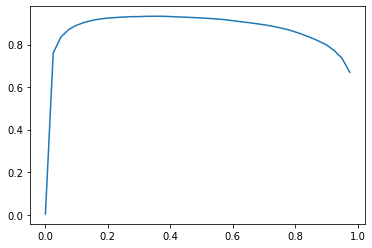

In [110]:
plt.plot(thresh_second_plus15, acc_second_plus15 )
plt.show()

In [111]:
print('max accuracy is' , max(acc_second_plus15))
print('best threshold is', thresh_second_plus15[np.argmax(acc_second_plus15)])

max accuracy is 0.9329348767701537
best threshold is 0.35


In [112]:
Test_data_second_strategy['KF_75+15_epochs_final pred'] = Test_data_second_strategy['AVG_KF_75+15_epochs'].apply(lambda x : np.where(x > 0.35, 1, 0))
wrong_final = Test_data_second_strategy[Test_data_second_strategy['KF_75+15_epochs_final pred'] !=Test_data_second_strategy['label'].astype(int)]
wrong_final

id label  \
41     b11d38879a191ae46e5faa3bc38280a1c353fff3.tif     1   
44     c462665961659b9b15af0fdab61c7725bfe7a37e.tif     1   
84     0e3676c7d2df7b6e1dab47a3d63061c845e2895f.tif     1   
88     b32740eda86d2730be229e0330c9f57250bebd9e.tif     1   
122    9d3b41f478029bb31707fe8048dea27fc4c980fc.tif     1   
...                                             ...   ...   
44032  f04af7f0929e70aecd4de07f3c22f683160fede7.tif     0   
44055  c84976300e21f882559f391faed50539736634fb.tif     1   
44063  240b3973e336e4b082f2d5a28574dc6b1bd671be.tif     1   
44078  aed33920dac44b9cc403939d880fe66922e4038e.tif     1   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   

       pred_KF1_75epochs_p  pred_KF2_75epochs_p  pred_KF3_75epochs_p  \
41                0.000079             0.000044             0.000043   
44                0.052817             0.267665             0.517954   
84                0.051129             0.011940             0.008511   
88                0.432716             0.112278             0.131001   
122               0.113027             0.067616             0.366879   
...                    ...                  ...                  ...   
44032             0.330810             0.544884             0.438414   
44055             0.164473             0.512587             0.128620   
44063             0.025092             0.083078             0.019045   
44078             0.087379             0.064737             0.500735   
44121             0.270364             0.946603             0.510005   

       pred_KF4_75epochs_p  pred_KF5_75epochs_p  AVG_KF_75_epochs  \
41                0.000179             0.000130          0.000095   
44                0.091196             0.028148          0.191556   
84                0.008980             0.055954          0.027303   
88                0.317025             0.612068          0.321018   
122               0.199424             0.166066          0.182602   
...                    ...                  ...               ...   
44032             0.605142             0.364887          0.456827   
44055             0.063780             0.748341          0.323560   
44063             0.013122             0.070441          0.042156   
44078             0.020842             0.030849          0.140908   
44121             0.670303             0.259289          0.531313   

       KF_75_epochs_final pred  pred_KF1_75+15epochs_p  \
41                           0                0.000279   
44                           0                0.050258   
84                           0                0.040411   
88                           0                0.351950   
122                          0                0.174518   
...                        ...                     ...   
44032                        1                0.450430   
44055                        0                0.144194   
44063                        0                0.032687   
44078                        0                0.079386   
44121                        1                0.271992   

       pred_KF2_75+15epochs_p  pred_KF3_75+15epochs_p  pred_KF4_75+15epochs_p  \
41                   0.000111                0.000022                0.001848   
44                   0.083742                0.697129                0.156058   
84                   0.016485                0.012834                0.017356   
88                   0.048058                0.134636                0.424473   
122                  0.079469                0.318544                0.319059   
...                       ...                     ...                     ...   
44032                0.644672                0.468468                0.950158   
44055                0.423674                0.275337                0.113094   
44063                0.031402                0.029331                0.021711   
44078                0.054664                0.702145                0.021943   
44121                0.289818     

**1430 missclassfied data points**

## Train for only 5 epochs

In [25]:
## 5 more epochs per model:

Train_data['label']= Train_data['label'].astype(str)
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
Y = Train_data['label']
n = len(Y)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Train'

from keras.callbacks import LearningRateScheduler
def decre( epochs, lr):
    if epochs < 1:
        return lr
    else:
        return lr*0.95

cb = LearningRateScheduler(decre)
  
fold_var = 1 

for train_index, val_index in kf.split(np.zeros(n),Y):

    training_data = Train_data.iloc[train_index]
    test_data = Train_data.iloc[val_index] 

    train_data_gen = idg.flow_from_dataframe(training_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size= 240)
    test_data_gen = idg.flow_from_dataframe(test_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size= 240 )

    model_name_to_load = 'Model_K_fold_Second_strategy'+str(fold_var)

    with open(model_name_to_load+'.json', 'r') as json_file:
            model= json_file.read()

    model = model_from_json(model) 
    model.load_weights(model_name_to_load+'.h5')

    METRICS = [
                keras.metrics.TruePositives(name='tp'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalseNegatives(name='fn'), 
                keras.metrics.BinaryAccuracy(name='accuracy'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc'),]

    opt = Adam(lr= 0.001 *0.90**25)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = METRICS)

    result = model.fit_generator(train_data_gen, steps_per_epoch=587   ,  callbacks= [cb], max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 5, validation_data = test_data_gen,  validation_steps = 147)

    model_name_to_save  = 'Model_K_fold_Second_strategy_plus_5_epochs'+ str(fold_var)

    mod = model.to_json()

    with open(model_name_to_save + ".json", "w") as file:
        file.write(mod)

    model.save_weights(model_name_to_save + ".h5")

    history_data = pd.DataFrame(result.history)
    history_data.to_csv('Model_K_fold_Second_strategy_plus_5_epochs'+ str(fold_var)+'.csv')


    fold_var +=1


Found 140720 validated image filenames belonging to 2 classes.
Found 35180 validated image filenames belonging to 2 classes.
Epoch 1/5
587/587 [==============================] - 215s 367ms/step - loss: 0.0898 - tp: 54320.0000 - fp: 1903.0000 - tn: 81831.0000 - fn: 2666.0000 - accuracy: 0.9675 - precision: 0.9662 - recall: 0.9532 - auc: 0.9940 - val_loss: 0.1565 - val_tp: 13368.0000 - val_fp: 518.0000 - val_tn: 20483.0000 - val_fn: 811.0000 - val_accuracy: 0.9622 - val_precision: 0.9627 - val_recall: 0.9428 - val_auc: 0.9913
Epoch 2/5
587/587 [==============================] - 214s 365ms/step - loss: 0.0903 - tp: 54297.0000 - fp: 1879.0000 - tn: 81855.0000 - fn: 2689.0000 - accuracy: 0.9675 - precision: 0.9666 - recall: 0.9528 - auc: 0.9939 - val_loss: 0.0582 - val_tp: 13433.0000 - val_fp: 613.0000 - val_tn: 20398.0000 - val_fn: 736.0000 - val_accuracy: 0.9617 - val_precision: 0.9564 - val_recall: 0.9481 - val_auc: 0.9919
Epoch 3/5
587/587 [==============================] - 215s 365ms/s

Epoch 5/5
587/587 [==============================] - 216s 367ms/step - loss: 0.0930 - tp: 53997.0000 - fp: 1941.0000 - tn: 82015.0000 - fn: 2767.0000 - accuracy: 0.9665 - precision: 0.9653 - recall: 0.9513 - auc: 0.9933 - val_loss: 0.1481 - val_tp: 13636.0000 - val_fp: 517.0000 - val_tn: 20272.0000 - val_fn: 755.0000 - val_accuracy: 0.9638 - val_precision: 0.9635 - val_recall: 0.9475 - val_auc: 0.9928
Found 140720 validated image filenames belonging to 2 classes.
Found 35180 validated image filenames belonging to 2 classes.
Epoch 1/5
587/587 [==============================] - 216s 368ms/step - loss: 0.0919 - tp: 54196.0000 - fp: 1878.0000 - tn: 81879.0000 - fn: 2767.0000 - accuracy: 0.9670 - precision: 0.9665 - recall: 0.9514 - auc: 0.9936 - val_loss: 0.0529 - val_tp: 13488.0000 - val_fp: 635.0000 - val_tn: 20356.0000 - val_fn: 701.0000 - val_accuracy: 0.9620 - val_precision: 0.9550 - val_recall: 0.9506 - val_auc: 0.9913
Epoch 2/5
587/587 [==============================] - 216s 368ms/s

In [113]:
idg_Test = ImageDataGenerator(rescale=1./255)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Test'

training_data = Test_data_second_strategy
training_data['label'] = training_data['label'].astype(str)

for i in range(1,6):

    with open('Model_K_fold_Second_strategy_plus_5_epochs'+str(i)+'.json', 'r') as json_file:
        model= json_file.read()

    model = model_from_json(model) 
    model.load_weights('Model_K_fold_Second_strategy_plus_5_epochs'+str(i)+'.h5')
    
    evaluation  = idg_Test.flow_from_dataframe(training_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = False, target_size=(96, 96), batch_size=240)
    
    results  = model.predict_generator(evaluation, steps = 184)
    Test_data_second_strategy['pred_KF'+str(i)+'_75+5epochs_p'] = results

Test_data_second_strategy

Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.


id label  \
0      8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0   
1      a106469bbfda4cdc5a9da7ac0152927bf1b4a92d.tif     0   
2      a1c001f6b242c72d3066f15ac6eb059ea72d30ba.tif     0   
3      5fc468030b7fdb5a0b656a45fa0dde5553dd9064.tif     0   
4      4e1e69b64cdeb757178fc5b657b4e5ea07e53935.tif     0   
...                                             ...   ...   
44120  5ba0f128323a89de471938df2ed33d7392a79b03.tif     0   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   
44122  9c0ad1bf43e2fa5e25fac5c8af616c5ae194c187.tif     0   
44123  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif     0   
44124  f129691c13433f66e1e0671ff1fe80944816f5a2.tif     0   

       pred_KF1_75epochs_p  pred_KF2_75epochs_p  pred_KF3_75epochs_p  \
0                 0.006126             0.033448             0.029508   
1                 0.001793             0.005494             0.001674   
2                 0.058916             0.038447             0.106363   
3                 0.000023             0.000782             0.000164   
4                 0.017487             0.028712             0.001856   
...                    ...                  ...                  ...   
44120             0.130902             0.671635             0.338447   
44121             0.270364             0.946603             0.510005   
44122             0.001324             0.000655             0.004051   
44123             0.263975             0.676696             0.018497   
44124             0.044646             0.008228             0.003385   

       pred_KF4_75epochs_p  pred_KF5_75epochs_p  AVG_KF_75_epochs  \
0                 0.000537             0.016902          0.017305   
1                 0.000165             0.003200          0.002465   
2                 0.037119             0.129210          0.074011   
3                 0.000005             0.000699          0.000335   
4                 0.003165             0.000918          0.010428   
...                    ...                  ...               ...   
44120             0.000412             0.411913          0.310661   
44121             0.670303             0.259289          0.531313   
44122             0.000255             0.001096          0.001476   
44123             0.022248             0.078435          0.211970   
44124             0.011667             0.035791          0.020743   

       KF_75_epochs_final pred  pred_KF1_75+15epochs_p  ...  \
0                            0                0.008596  ...   
1                            0                0.002032  ...   
2                            0                0.055883  ...   
3                            0                0.000029  ...   
4                            0                0.020768  ...   
...                        ...                     ...  ...   
44120                        0                0.352518  ...   
44121                        1                0.271992  ...   
44122                        0                0.001484  ...   
44123                        0                0.174029  ...   
44124                        0                0.057423  ...   

       pred_KF3_75+15epochs_p  pred_KF4_75+15epochs_p  pred_KF5_75+15epochs_p  \
0                    0.033330                0.001871                0.015334   
1                    0.001196                0.000252                0.000628   
2                    0.068158                0.205356                0.134547   
3                    0.000355                0.000013                0.000549   
4                    0.002897                0.004439                0.000627   
...                       ...                     ...                     ...   
44120                0.038775                0.000254                0.628105   
44121                0.591592                0.921095                0.136590   
44122                0.005441                0.000363                0.000566   
44123                0.017015                0.075357  

In [114]:
Test_data_second_strategy['AVG_KF_75+5_epochs'] = Test_data_second_strategy[['pred_KF1_75+5epochs_p', 'pred_KF2_75+5epochs_p','pred_KF3_75+5epochs_p','pred_KF4_75+5epochs_p','pred_KF5_75+5epochs_p']].mean(axis =1)

# find best threshold

thresh_second_plus5 = []
acc_second_plus5 = []
for i in range(80):
    p = i/80
    thresh_second_plus5.append(p)
    pred = Test_data_second_strategy['AVG_KF_75+5_epochs'].apply(lambda x : np.where(x > p, 1, 0))
    acc_second_plus5.append(balanced_accuracy_score(Test_data_second_strategy['label'].astype(int), pred.astype(int), adjusted = True))

In [115]:
print('max accuracy is' , max(acc_second_plus5))
print('best threshold is', thresh_second_plus5[np.argmax(acc_second_plus5)])

max accuracy is 0.9334143105127808
best threshold is 0.35


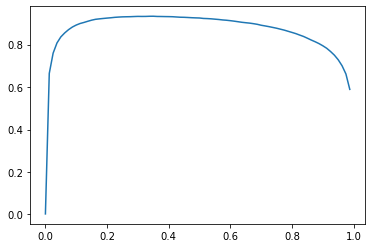

In [116]:
plt.plot(thresh_second_plus5,acc_second_plus5 )
plt.show()

In [117]:
Test_data_second_strategy['KF_75+5_epochs_final pred'] = Test_data_second_strategy['AVG_KF_75+5_epochs'].apply(lambda x : np.where(x > 0.35, 1, 0))
wrong_final = Test_data_second_strategy[Test_data_second_strategy['KF_75+5_epochs_final pred'] !=Test_data_second_strategy['label'].astype(int)]
wrong_final

id label  \
41     b11d38879a191ae46e5faa3bc38280a1c353fff3.tif     1   
44     c462665961659b9b15af0fdab61c7725bfe7a37e.tif     1   
84     0e3676c7d2df7b6e1dab47a3d63061c845e2895f.tif     1   
88     b32740eda86d2730be229e0330c9f57250bebd9e.tif     1   
122    9d3b41f478029bb31707fe8048dea27fc4c980fc.tif     1   
...                                             ...   ...   
43992  d1f1bb04a0b0d6b58674fd22ab7eac7bbe0ccf04.tif     0   
44032  f04af7f0929e70aecd4de07f3c22f683160fede7.tif     0   
44063  240b3973e336e4b082f2d5a28574dc6b1bd671be.tif     1   
44078  aed33920dac44b9cc403939d880fe66922e4038e.tif     1   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   

       pred_KF1_75epochs_p  pred_KF2_75epochs_p  pred_KF3_75epochs_p  \
41                0.000079             0.000044             0.000043   
44                0.052817             0.267665             0.517954   
84                0.051129             0.011940             0.008511   
88                0.432716             0.112278             0.131001   
122               0.113027             0.067616             0.366879   
...                    ...                  ...                  ...   
43992             0.318170             0.848792             0.019144   
44032             0.330810             0.544884             0.438414   
44063             0.025092             0.083078             0.019045   
44078             0.087379             0.064737             0.500735   
44121             0.270364             0.946603             0.510005   

       pred_KF4_75epochs_p  pred_KF5_75epochs_p  AVG_KF_75_epochs  \
41                0.000179             0.000130          0.000095   
44                0.091196             0.028148          0.191556   
84                0.008980             0.055954          0.027303   
88                0.317025             0.612068          0.321018   
122               0.199424             0.166066          0.182602   
...                    ...                  ...               ...   
43992             0.499352             0.823382          0.501768   
44032             0.605142             0.364887          0.456827   
44063             0.013122             0.070441          0.042156   
44078             0.020842             0.030849          0.140908   
44121             0.670303             0.259289          0.531313   

       KF_75_epochs_final pred  pred_KF1_75+15epochs_p  ...  \
41                           0                0.000279  ...   
44                           0                0.050258  ...   
84                           0                0.040411  ...   
88                           0                0.351950  ...   
122                          0                0.174518  ...   
...                        ...                     ...  ...   
43992                        1                0.299330  ...   
44032                        1                0.450430  ...   
44063                        0                0.032687  ...   
44078                        0                0.079386  ...   
44121                        1                0.271992  ...   

       pred_KF5_75+15epochs_p  AVG_KF_75+15_epochs  \
41                   0.000026             0.000457   
44                   0.020213             0.201480   
84                   0.026594             0.022736   
88                   0.547284             0.301280   
122                  0.226383             0.223594   
...                       ...                  ...   
43992                0.645234             0.537173   
44032                0.190622             0.540870   
44063                0.039889             0.031004   
44078                0.022503             0.176128   
44121                0.136590             0.442217   

       KF_75+15_epochs_final pred  pred_KF1_75+5epochs_p  \
41                              0               0.000203   
44                              0               0.266809   
84                              0   

**The number of misclassified dropped to 1417**

In [118]:
# plot the AUC score 
from sklearn.metrics import roc_auc_score
roc_auc_score(Test_data_second_strategy['label'], Test_data_second_strategy['AVG_KF_75+5_epochs'])

0.994215286797816

# K FOLD VALIDATION APPROACH _ VERSION 2:
## Deeper , 100 epochs, smaller lr decay on after 50 epochs, TIME TEST AUGMENTATION (5 times) 

In [7]:
idg = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.25,
        height_shift_range=0.25,
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest')

In [12]:
Train_data['label']= Train_data['label'].astype(str)
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
Y = Train_data['label']
n = len(Y)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Train'

from keras.callbacks import LearningRateScheduler , EarlyStopping
from keras.layers import BatchNormalization

def decre( epochs, lr):
    if epochs < 50:
        return lr
    else:
        return lr*0.93

cb1 = LearningRateScheduler(decre)
cb2 = EarlyStopping(monitor = 'val_auc', patience = 4)

  
fold_var = 1 
for train_index, val_index in kf.split(np.zeros(n),Y):
    training_data = Train_data.iloc[train_index]
    test_data = Train_data.iloc[val_index] 
    
    train_data_gen = idg.flow_from_dataframe(training_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size=240)
    test_data_gen = idg.flow_from_dataframe(test_data, directory =image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = True, target_size=(96, 96), batch_size=240 )
    
    model = Sequential()
    model.add(Conv2D(128, (3,3), activation = 'relu', input_shape = (96,96,3), padding ='same'))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding ='same'))
    model.add(BatchNormalization()) # extra
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding ='same'))
    model.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
    model.add(BatchNormalization()) # extra
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
    model.add(Conv2D(128, (3,3), activation = 'relu',  padding ='same'))
    model.add(BatchNormalization()) # extra
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))
    model.add(Conv2D(96, (3,3), activation = 'relu',  padding ='same'))  # extra 
    model.add(BatchNormalization()) # extra
    model.add(Flatten())
    model.add(Dropout(0.25))  # extra
    model.add(Dense(380, activation = 'relu'))  # from 375
    model.add(Dropout(0.25))
    model.add(Dense(380, activation = 'relu')) # from 375
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()

    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),]

    opt = Adam(lr= 0.001)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = METRICS)
    
    result = model.fit_generator(train_data_gen, steps_per_epoch=587,  max_queue_size=5, workers=6, use_multiprocessing=False, epochs = 100, callbacks = [cb1, cb2], validation_data = test_data_gen,  validation_steps = 147)
    
    model_name  = 'Model_K_fold_'+ str(fold_var) + "_VERSION 2"
    mod = model.to_json()
    
    with open(model_name + ".json", "w") as file:
        file.write(mod)
    
    model.save_weights(model_name + ".h5")

    history_data = pd.DataFrame(result.history)
    history_data.to_csv('Model_K_fold_'+ str(fold_var)+'VERSION 2'+'.csv')
    

    fold_var +=1


Found 140720 validated image filenames belonging to 2 classes.
Found 35180 validated image filenames belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 96, 96, 128)       3584      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 96, 96, 128)       147584    
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 128)       512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 48, 48, 128)       147584

587/587 [==============================] - 266s 453ms/step - loss: 0.1099 - tp: 53777.0000 - fp: 2374.0000 - tn: 81360.0000 - fn: 3209.0000 - accuracy: 0.9603 - precision: 0.9577 - recall: 0.9437 - auc: 0.9910 - val_loss: 1.9261 - val_tp: 5861.0000 - val_fp: 516.0000 - val_tn: 20495.0000 - val_fn: 8308.0000 - val_accuracy: 0.7492 - val_precision: 0.9191 - val_recall: 0.4136 - val_auc: 0.7054
Epoch 34/100
587/587 [==============================] - 266s 453ms/step - loss: 0.1078 - tp: 53865.0000 - fp: 2319.0000 - tn: 81415.0000 - fn: 3121.0000 - accuracy: 0.9613 - precision: 0.9587 - recall: 0.9452 - auc: 0.9914 - val_loss: 1.2273 - val_tp: 7665.0000 - val_fp: 995.0000 - val_tn: 20016.0000 - val_fn: 6504.0000 - val_accuracy: 0.7868 - val_precision: 0.8851 - val_recall: 0.5410 - val_auc: 0.8045
Epoch 35/100
587/587 [==============================] - 266s 453ms/step - loss: 0.1083 - tp: 53898.0000 - fp: 2347.0000 - tn: 81387.0000 - fn: 3088.0000 - accuracy: 0.9614 - precision: 0.9583 - rec

587/587 [==============================] - 266s 453ms/step - loss: 0.0597 - tp: 55315.0000 - fp: 1287.0000 - tn: 82447.0000 - fn: 1671.0000 - accuracy: 0.9790 - precision: 0.9773 - recall: 0.9707 - auc: 0.9971 - val_loss: 0.0997 - val_tp: 13729.0000 - val_fp: 1282.0000 - val_tn: 19729.0000 - val_fn: 440.0000 - val_accuracy: 0.9511 - val_precision: 0.9146 - val_recall: 0.9689 - val_auc: 0.9902
Epoch 74/100
587/587 [==============================] - 266s 453ms/step - loss: 0.0588 - tp: 55390.0000 - fp: 1302.0000 - tn: 82432.0000 - fn: 1596.0000 - accuracy: 0.9794 - precision: 0.9770 - recall: 0.9720 - auc: 0.9971 - val_loss: 0.1182 - val_tp: 13317.0000 - val_fp: 633.0000 - val_tn: 20378.0000 - val_fn: 852.0000 - val_accuracy: 0.9578 - val_precision: 0.9546 - val_recall: 0.9399 - val_auc: 0.9891
Epoch 75/100
587/587 [==============================] - 266s 453ms/step - loss: 0.0603 - tp: 55293.0000 - fp: 1312.0000 - tn: 82422.0000 - fn: 1693.0000 - accuracy: 0.9786 - precision: 0.9768 - re

587/587 [==============================] - 267s 455ms/step - loss: 0.2187 - tp: 49941.0000 - fp: 4938.0000 - tn: 78830.0000 - fn: 7011.0000 - accuracy: 0.9151 - precision: 0.9100 - recall: 0.8769 - auc: 0.9678 - val_loss: 0.3533 - val_tp: 10067.0000 - val_fp: 477.0000 - val_tn: 20500.0000 - val_fn: 4136.0000 - val_accuracy: 0.8689 - val_precision: 0.9548 - val_recall: 0.7088 - val_auc: 0.9557
Epoch 6/100
587/587 [==============================] - 267s 455ms/step - loss: 0.2063 - tp: 50318.0000 - fp: 4563.0000 - tn: 79205.0000 - fn: 6634.0000 - accuracy: 0.9204 - precision: 0.9169 - recall: 0.8835 - auc: 0.9711 - val_loss: 0.5391 - val_tp: 7290.0000 - val_fp: 687.0000 - val_tn: 20290.0000 - val_fn: 6913.0000 - val_accuracy: 0.7840 - val_precision: 0.9139 - val_recall: 0.5133 - val_auc: 0.8316
Epoch 7/100
587/587 [==============================] - 267s 455ms/step - loss: 0.1986 - tp: 50638.0000 - fp: 4646.0000 - tn: 79122.0000 - fn: 6314.0000 - accuracy: 0.9221 - precision: 0.9160 - reca

587/587 [==============================] - 267s 454ms/step - loss: 0.0981 - tp: 54224.0000 - fp: 2062.0000 - tn: 81706.0000 - fn: 2728.0000 - accuracy: 0.9660 - precision: 0.9634 - recall: 0.9521 - auc: 0.9926 - val_loss: 0.1660 - val_tp: 13321.0000 - val_fp: 1048.0000 - val_tn: 19929.0000 - val_fn: 882.0000 - val_accuracy: 0.9451 - val_precision: 0.9271 - val_recall: 0.9379 - val_auc: 0.9848
Epoch 46/100
587/587 [==============================] - 267s 455ms/step - loss: 0.0963 - tp: 54239.0000 - fp: 2092.0000 - tn: 81676.0000 - fn: 2713.0000 - accuracy: 0.9659 - precision: 0.9629 - recall: 0.9524 - auc: 0.9929 - val_loss: 0.4801 - val_tp: 11785.0000 - val_fp: 2285.0000 - val_tn: 18692.0000 - val_fn: 2418.0000 - val_accuracy: 0.8663 - val_precision: 0.8376 - val_recall: 0.8298 - val_auc: 0.9147
Epoch 47/100
587/587 [==============================] - 267s 455ms/step - loss: 0.0961 - tp: 54223.0000 - fp: 2095.0000 - tn: 81673.0000 - fn: 2729.0000 - accuracy: 0.9657 - precision: 0.9628 - 

587/587 [==============================] - 267s 454ms/step - loss: 0.0573 - tp: 55327.0000 - fp: 1242.0000 - tn: 82526.0000 - fn: 1625.0000 - accuracy: 0.9796 - precision: 0.9780 - recall: 0.9715 - auc: 0.9973 - val_loss: 0.0850 - val_tp: 13378.0000 - val_fp: 321.0000 - val_tn: 20656.0000 - val_fn: 825.0000 - val_accuracy: 0.9674 - val_precision: 0.9766 - val_recall: 0.9419 - val_auc: 0.9941
Epoch 86/100
587/587 [==============================] - 267s 455ms/step - loss: 0.0564 - tp: 55392.0000 - fp: 1206.0000 - tn: 82562.0000 - fn: 1560.0000 - accuracy: 0.9803 - precision: 0.9787 - recall: 0.9726 - auc: 0.9974 - val_loss: 0.0534 - val_tp: 13477.0000 - val_fp: 328.0000 - val_tn: 20649.0000 - val_fn: 726.0000 - val_accuracy: 0.9700 - val_precision: 0.9762 - val_recall: 0.9489 - val_auc: 0.9949
Epoch 87/100
587/587 [==============================] - 267s 454ms/step - loss: 0.0572 - tp: 55375.0000 - fp: 1228.0000 - tn: 82540.0000 - fn: 1577.0000 - accuracy: 0.9801 - precision: 0.9783 - rec

Epoch 1/100
587/587 [==============================] - 269s 459ms/step - loss: 0.4123 - tp: 42886.0000 - fp: 10416.0000 - tn: 73351.0000 - fn: 14067.0000 - accuracy: 0.8260 - precision: 0.8046 - recall: 0.7530 - auc: 0.8927 - val_loss: 1.8397 - val_tp: 14153.0000 - val_fp: 17995.0000 - val_tn: 2970.0000 - val_fn: 62.0000 - val_accuracy: 0.4867 - val_precision: 0.4402 - val_recall: 0.9956 - val_auc: 0.8332
Epoch 2/100
587/587 [==============================] - 268s 456ms/step - loss: 0.3124 - tp: 46529.0000 - fp: 7924.0000 - tn: 75853.0000 - fn: 10414.0000 - accuracy: 0.8697 - precision: 0.8545 - recall: 0.8171 - auc: 0.9365 - val_loss: 1.4769 - val_tp: 3167.0000 - val_fp: 226.0000 - val_tn: 20742.0000 - val_fn: 11045.0000 - val_accuracy: 0.6796 - val_precision: 0.9334 - val_recall: 0.2228 - val_auc: 0.5974
Epoch 3/100
587/587 [==============================] - 267s 456ms/step - loss: 0.2718 - tp: 48034.0000 - fp: 6708.0000 - tn: 77069.0000 - fn: 8909.0000 - accuracy: 0.8890 - precision

587/587 [==============================] - 268s 456ms/step - loss: 0.1010 - tp: 54021.0000 - fp: 2105.0000 - tn: 81672.0000 - fn: 2922.0000 - accuracy: 0.9643 - precision: 0.9625 - recall: 0.9487 - auc: 0.9924 - val_loss: 0.3457 - val_tp: 12384.0000 - val_fp: 2907.0000 - val_tn: 18061.0000 - val_fn: 1828.0000 - val_accuracy: 0.8654 - val_precision: 0.8099 - val_recall: 0.8714 - val_auc: 0.9362
Epoch 42/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0987 - tp: 54114.0000 - fp: 2123.0000 - tn: 81654.0000 - fn: 2829.0000 - accuracy: 0.9648 - precision: 0.9622 - recall: 0.9503 - auc: 0.9927 - val_loss: 0.5407 - val_tp: 10056.0000 - val_fp: 1196.0000 - val_tn: 19772.0000 - val_fn: 4156.0000 - val_accuracy: 0.8479 - val_precision: 0.8937 - val_recall: 0.7076 - val_auc: 0.9030
Epoch 43/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0972 - tp: 54155.0000 - fp: 2073.0000 - tn: 81704.0000 - fn: 2788.0000 - accuracy: 0.9655 - precision: 0.9631 -

587/587 [==============================] - 268s 456ms/step - loss: 0.0569 - tp: 55403.0000 - fp: 1294.0000 - tn: 82483.0000 - fn: 1540.0000 - accuracy: 0.9799 - precision: 0.9772 - recall: 0.9730 - auc: 0.9972 - val_loss: 0.0998 - val_tp: 13798.0000 - val_fp: 797.0000 - val_tn: 20171.0000 - val_fn: 414.0000 - val_accuracy: 0.9656 - val_precision: 0.9454 - val_recall: 0.9709 - val_auc: 0.9939
Epoch 82/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0550 - tp: 55410.0000 - fp: 1209.0000 - tn: 82568.0000 - fn: 1533.0000 - accuracy: 0.9805 - precision: 0.9786 - recall: 0.9731 - auc: 0.9974 - val_loss: 0.0421 - val_tp: 13793.0000 - val_fp: 603.0000 - val_tn: 20365.0000 - val_fn: 419.0000 - val_accuracy: 0.9709 - val_precision: 0.9581 - val_recall: 0.9705 - val_auc: 0.9947
Epoch 83/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0553 - tp: 55422.0000 - fp: 1245.0000 - tn: 82532.0000 - fn: 1521.0000 - accuracy: 0.9803 - precision: 0.9780 - rec

Found 35180 validated image filenames belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 96, 96, 128)       3584      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 96, 96, 128)       147584    
_________________________________________________________________
batch_normalization_25 (Batc (None, 96, 96, 128)       512       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 48, 48, 128)       147584    
__________________________________________________________

587/587 [==============================] - 268s 456ms/step - loss: 0.1091 - tp: 53604.0000 - fp: 2243.0000 - tn: 81713.0000 - fn: 3160.0000 - accuracy: 0.9616 - precision: 0.9598 - recall: 0.9443 - auc: 0.9912 - val_loss: 0.2942 - val_tp: 13204.0000 - val_fp: 3353.0000 - val_tn: 17436.0000 - val_fn: 1187.0000 - val_accuracy: 0.8709 - val_precision: 0.7975 - val_recall: 0.9175 - val_auc: 0.9521
Epoch 34/100
587/587 [==============================] - 268s 457ms/step - loss: 0.1065 - tp: 53676.0000 - fp: 2354.0000 - tn: 81602.0000 - fn: 3088.0000 - accuracy: 0.9613 - precision: 0.9580 - recall: 0.9456 - auc: 0.9916 - val_loss: 0.1569 - val_tp: 13540.0000 - val_fp: 1483.0000 - val_tn: 19306.0000 - val_fn: 851.0000 - val_accuracy: 0.9337 - val_precision: 0.9013 - val_recall: 0.9409 - val_auc: 0.9820
Epoch 35/100
587/587 [==============================] - 268s 456ms/step - loss: 0.1051 - tp: 53728.0000 - fp: 2301.0000 - tn: 81655.0000 - fn: 3036.0000 - accuracy: 0.9621 - precision: 0.9589 - 

587/587 [==============================] - 267s 455ms/step - loss: 0.0604 - tp: 55135.0000 - fp: 1367.0000 - tn: 82589.0000 - fn: 1629.0000 - accuracy: 0.9787 - precision: 0.9758 - recall: 0.9713 - auc: 0.9970 - val_loss: 0.2412 - val_tp: 12364.0000 - val_fp: 351.0000 - val_tn: 20438.0000 - val_fn: 2027.0000 - val_accuracy: 0.9324 - val_precision: 0.9724 - val_recall: 0.8591 - val_auc: 0.9764
Epoch 74/100
587/587 [==============================] - 267s 455ms/step - loss: 0.0589 - tp: 55192.0000 - fp: 1290.0000 - tn: 82666.0000 - fn: 1572.0000 - accuracy: 0.9797 - precision: 0.9772 - recall: 0.9723 - auc: 0.9971 - val_loss: 0.0815 - val_tp: 14017.0000 - val_fp: 770.0000 - val_tn: 20019.0000 - val_fn: 374.0000 - val_accuracy: 0.9675 - val_precision: 0.9479 - val_recall: 0.9740 - val_auc: 0.9947
Epoch 75/100
587/587 [==============================] - 267s 455ms/step - loss: 0.0590 - tp: 55083.0000 - fp: 1291.0000 - tn: 82665.0000 - fn: 1681.0000 - accuracy: 0.9789 - precision: 0.9771 - re

587/587 [==============================] - 268s 457ms/step - loss: 0.2171 - tp: 49919.0000 - fp: 4812.0000 - tn: 78933.0000 - fn: 7056.0000 - accuracy: 0.9157 - precision: 0.9121 - recall: 0.8762 - auc: 0.9684 - val_loss: 0.4898 - val_tp: 9127.0000 - val_fp: 1314.0000 - val_tn: 19686.0000 - val_fn: 5053.0000 - val_accuracy: 0.8190 - val_precision: 0.8741 - val_recall: 0.6437 - val_auc: 0.8851
Epoch 6/100
587/587 [==============================] - 268s 456ms/step - loss: 0.2013 - tp: 50653.0000 - fp: 4507.0000 - tn: 79238.0000 - fn: 6322.0000 - accuracy: 0.9230 - precision: 0.9183 - recall: 0.8890 - auc: 0.9725 - val_loss: 0.5951 - val_tp: 6488.0000 - val_fp: 262.0000 - val_tn: 20738.0000 - val_fn: 7692.0000 - val_accuracy: 0.7739 - val_precision: 0.9612 - val_recall: 0.4575 - val_auc: 0.8356
Epoch 7/100
587/587 [==============================] - 269s 458ms/step - loss: 0.1898 - tp: 50945.0000 - fp: 4254.0000 - tn: 79491.0000 - fn: 6030.0000 - accuracy: 0.9269 - precision: 0.9229 - reca

587/587 [==============================] - 268s 456ms/step - loss: 0.0935 - tp: 54228.0000 - fp: 1955.0000 - tn: 81790.0000 - fn: 2747.0000 - accuracy: 0.9666 - precision: 0.9652 - recall: 0.9518 - auc: 0.9933 - val_loss: 0.1428 - val_tp: 13530.0000 - val_fp: 1150.0000 - val_tn: 19850.0000 - val_fn: 650.0000 - val_accuracy: 0.9488 - val_precision: 0.9217 - val_recall: 0.9542 - val_auc: 0.9884
Epoch 46/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0930 - tp: 54266.0000 - fp: 1964.0000 - tn: 81781.0000 - fn: 2709.0000 - accuracy: 0.9668 - precision: 0.9651 - recall: 0.9525 - auc: 0.9933 - val_loss: 0.2512 - val_tp: 11987.0000 - val_fp: 886.0000 - val_tn: 20114.0000 - val_fn: 2193.0000 - val_accuracy: 0.9125 - val_precision: 0.9312 - val_recall: 0.8453 - val_auc: 0.9585
Epoch 47/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0927 - tp: 54325.0000 - fp: 1958.0000 - tn: 81787.0000 - fn: 2650.0000 - accuracy: 0.9673 - precision: 0.9652 - r

587/587 [==============================] - 268s 456ms/step - loss: 0.0526 - tp: 55546.0000 - fp: 1140.0000 - tn: 82605.0000 - fn: 1429.0000 - accuracy: 0.9817 - precision: 0.9799 - recall: 0.9749 - auc: 0.9977 - val_loss: 0.0566 - val_tp: 13774.0000 - val_fp: 553.0000 - val_tn: 20447.0000 - val_fn: 406.0000 - val_accuracy: 0.9727 - val_precision: 0.9614 - val_recall: 0.9714 - val_auc: 0.9954
Epoch 86/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0526 - tp: 55554.0000 - fp: 1180.0000 - tn: 82565.0000 - fn: 1421.0000 - accuracy: 0.9815 - precision: 0.9792 - recall: 0.9751 - auc: 0.9976 - val_loss: 0.0468 - val_tp: 13705.0000 - val_fp: 428.0000 - val_tn: 20572.0000 - val_fn: 475.0000 - val_accuracy: 0.9743 - val_precision: 0.9697 - val_recall: 0.9665 - val_auc: 0.9956
Epoch 87/100
587/587 [==============================] - 268s 456ms/step - loss: 0.0526 - tp: 55526.0000 - fp: 1203.0000 - tn: 82542.0000 - fn: 1449.0000 - accuracy: 0.9812 - precision: 0.9788 - rec

In [4]:
test_data = pd.read_csv('Test_data.csv').drop('Unnamed: 0', axis =1)

In [5]:
from keras.models import model_from_json

In [8]:
#idg_Test = ImageDataGenerator(rescale=1./255)
image_dir = 'C:\\Users\\Gianluca\\Hist Cancer\\K-fold\\Test'

test_data['label'] = test_data['label'].astype(str)

for aug in range(1,6):
    for i in range(1,6):

        with open('Model_K_fold_'+str(i)+ "_VERSION 2"+'.json', 'r') as json_file:
            model= json_file.read()

        model = model_from_json(model) 
        model.load_weights('Model_K_fold_'+str(i)+ "_VERSION 2"+'.h5')

        evaluation  = idg.flow_from_dataframe(test_data, directory = image_dir, x_col ='id', y_col = 'label', class_mode = 'binary', shuffle = False, target_size=(96, 96), batch_size=240)

        results  = model.predict_generator(evaluation, steps = 184)
        test_data['pred_KF'+str(i)+'_VERSION_2_AUG'+str(aug)] = results

test_data

Found 44125 validated image filenames belonging to 2 classes.

Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 44125 validated image filenames belonging to 2 classes.
Found 4

Unnamed: 0                                            id label  \
0               9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0   
1              10  a106469bbfda4cdc5a9da7ac0152927bf1b4a92d.tif     0   
2              16  a1c001f6b242c72d3066f15ac6eb059ea72d30ba.tif     0   
3              21  5fc468030b7fdb5a0b656a45fa0dde5553dd9064.tif     0   
4              22  4e1e69b64cdeb757178fc5b657b4e5ea07e53935.tif     0   
...           ...                                           ...   ...   
44120      220011  5ba0f128323a89de471938df2ed33d7392a79b03.tif     0   
44121      220013  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   
44122      220015  9c0ad1bf43e2fa5e25fac5c8af616c5ae194c187.tif     0   
44123      220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif     0   
44124      220023  f129691c13433f66e1e0671ff1fe80944816f5a2.tif     0   

       pred_KF1_VERSION_2_AUG1  pred_KF2_VERSION_2_AUG1  \
0                     0.005353                 0.003794   
1                     0.000160                 0.000006   
2                     0.049714                 0.053623   
3                     0.000012                 0.000136   
4                     0.003439                 0.009578   
...                        ...                      ...   
44120                 0.000402                 0.000058   
44121                 0.422731                 0.213000   
44122                 0.013657                 0.002626   
44123                 0.007207                 0.036037   
44124                 0.004372                 0.001074   

       pred_KF3_VERSION_2_AUG1  pred_KF4_VERSION_2_AUG1  \
0                     0.055535                 0.005031   
1                     0.000033                 0.000365   
2                     0.080768                 0.154727   
3                     0.000016                 0.005186   
4                     0.015329                 0.054367   
...                        ...                      ...   
44120                 0.007419                 0.008396   
44121                 0.172178                 0.852657   
44122                 0.055512                 0.000809   
44123                 0.002845                 0.002508   
44124                 0.005482                 0.002348   

       pred_KF5_VERSION_2_AUG1  pred_KF1_VERSION_2_AUG2  \
0                     0.000578                 0.006973   
1                     0.001031                 0.000070   
2                     0.040196                 0.016029   
3                     0.000477                 0.000225   
4                     0.094102                 0.006980   
...                        ...                      ...   
44120                 0.005075                 0.001181   
44121                 0.239633                 0.238208   
44122                 0.000022                 0.003932   
44123                 0.000480                 0.000464   
44124                 0.088623                 0.021057   

       pred_KF2_VERSION_2_AUG2  ...  pred_KF1_VERSION_2_AUG4  \
0                     0.059881  ...                 0.002376   
1                     0.001214  ...                 0.000236   
2                     0.011295  ...                 0.012658   
3                     0.000367  ...                 0.000083   
4                     0.010859  ...                 0.029555   
...                        ...  ...                      ...   
44120                 0.000014  ...                 0.000010   
44121                 0.307977  ...                 0.055890   
44122                 0.000557  ...                 0.001419   
44123                 0.011352  ...                 0.000658   
44124                 0.010592  ...                 0.039138   

       pred_KF2_VERSION_2_AUG4  pred_KF3_VERSION_2_AUG4  \
0                     0.362454                 0.113030   
1                     0.000008                 0.000059   
2                     0.039554                 0.063546  

In [30]:
list_pred = [ 'pred_KF'+str(i)+'_VERSION_2_AUG'+str(aug) for i in range(1,6) for aug in range (1,6)]

In [29]:
test_data['AVG version 2'] = np.mean(test_data[list_pred], axis = 1)
test_data

id label  \
0      8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0   
1      a106469bbfda4cdc5a9da7ac0152927bf1b4a92d.tif     0   
2      a1c001f6b242c72d3066f15ac6eb059ea72d30ba.tif     0   
3      5fc468030b7fdb5a0b656a45fa0dde5553dd9064.tif     0   
4      4e1e69b64cdeb757178fc5b657b4e5ea07e53935.tif     0   
...                                             ...   ...   
44120  5ba0f128323a89de471938df2ed33d7392a79b03.tif     0   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   
44122  9c0ad1bf43e2fa5e25fac5c8af616c5ae194c187.tif     0   
44123  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif     0   
44124  f129691c13433f66e1e0671ff1fe80944816f5a2.tif     0   

       pred_KF1_VERSION_2_AUG1  pred_KF2_VERSION_2_AUG1  \
0                     0.005353                 0.003794   
1                     0.000160                 0.000006   
2                     0.049714                 0.053623   
3                     0.000012                 0.000136   
4                     0.003439                 0.009578   
...                        ...                      ...   
44120                 0.000402                 0.000058   
44121                 0.422731                 0.213000   
44122                 0.013657                 0.002626   
44123                 0.007207                 0.036037   
44124                 0.004372                 0.001074   

       pred_KF3_VERSION_2_AUG1  pred_KF4_VERSION_2_AUG1  \
0                     0.055535                 0.005031   
1                     0.000033                 0.000365   
2                     0.080768                 0.154727   
3                     0.000016                 0.005186   
4                     0.015329                 0.054367   
...                        ...                      ...   
44120                 0.007419                 0.008396   
44121                 0.172178                 0.852657   
44122                 0.055512                 0.000809   
44123                 0.002845                 0.002508   
44124                 0.005482                 0.002348   

       pred_KF5_VERSION_2_AUG1  pred_KF1_VERSION_2_AUG2  \
0                     0.000578                 0.006973   
1                     0.001031                 0.000070   
2                     0.040196                 0.016029   
3                     0.000477                 0.000225   
4                     0.094102                 0.006980   
...                        ...                      ...   
44120                 0.005075                 0.001181   
44121                 0.239633                 0.238208   
44122                 0.000022                 0.003932   
44123                 0.000480                 0.000464   
44124                 0.088623                 0.021057   

       pred_KF2_VERSION_2_AUG2  pred_KF3_VERSION_2_AUG2  ...  \
0                     0.059881                 0.006314  ...   
1                     0.001214                 0.000081  ...   
2                     0.011295                 0.026415  ...   
3                     0.000367                 0.000110  ...   
4                     0.010859                 0.010941  ...   
...                        ...                      ...  ...   
44120                 0.000014                 0.028810  ...   
44121                 0.307977                 0.191892  ...   
44122                 0.000557                 0.007940  ...   
44123                 0.011352                 0.000376  ...   
44124                 0.010592                 0.006243  ...   

       pred_KF3_VERSION_2_AUG4  pred_KF4_VERSION_2_AUG4  \
0                     0.113030                 0.003527   
1                     0.000059                 0.000052   
2                     0.063546                 0.410462   
3                     0.000173                 0.000449   
4                     0.003127                 0.167611   
...                        ...                      ...   
44120  

In [31]:
version2_acc = []
version2_thre = []

for i in range (100):
    p = i/100
    version2_thre.append(p)
    pred  = np.where(test_data['AVG version 2']>p,1,0)
    version2_acc.append(balanced_accuracy_score(test_data['label'].astype(int), pred.astype(int), adjusted = True))

max accuracy is 0.9669614771896977
best threshold is 0.44


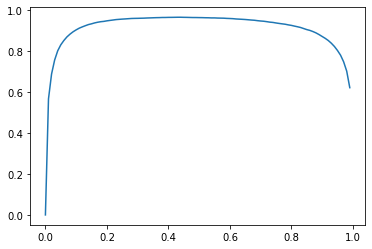

In [32]:
print('max accuracy is' , max(version2_acc))
print('best threshold is', version2_thre[np.argmax(version2_acc)])

plt.plot(version2_thre,    version2_acc )
plt.show()

In [33]:
test_data['VERSION 2 PRED'] = test_data['AVG version 2'].apply(lambda x : np.where(x > 0.44, 1, 0))
wrong_final = test_data[test_data['VERSION 2 PRED'] !=test_data['label'].astype(int)]
wrong_final

id label  \
41     b11d38879a191ae46e5faa3bc38280a1c353fff3.tif     1   
84     0e3676c7d2df7b6e1dab47a3d63061c845e2895f.tif     1   
122    9d3b41f478029bb31707fe8048dea27fc4c980fc.tif     1   
172    1048f0c12198635d8b2db25f233be11e8942a80a.tif     0   
205    2adae1de86bcaa43d884121a71bc86b0472a7f12.tif     0   
...                                             ...   ...   
44032  f04af7f0929e70aecd4de07f3c22f683160fede7.tif     0   
44057  68d9005d7e9d0799c0099eec3a902b6d007b50f9.tif     0   
44063  240b3973e336e4b082f2d5a28574dc6b1bd671be.tif     1   
44078  aed33920dac44b9cc403939d880fe66922e4038e.tif     1   
44121  1092801a1d1d7cc8e45b1d909c553ea400615d68.tif     0   

       pred_KF1_VERSION_2_AUG1  pred_KF2_VERSION_2_AUG1  \
41                    0.006055                 0.129975   
84                    0.115586                 0.265152   
122                   0.133492                 0.373058   
172                   0.035759                 0.827017   
205                   0.028014                 0.520571   
...                        ...                      ...   
44032                 0.222414                 0.456377   
44057                 0.928487                 0.637838   
44063                 0.322463                 0.199417   
44078                 0.042331                 0.266018   
44121                 0.422731                 0.213000   

       pred_KF3_VERSION_2_AUG1  pred_KF4_VERSION_2_AUG1  \
41                    0.014067                 0.004081   
84                    0.079622                 0.648456   
122                   0.217376                 0.054284   
172                   0.196268                 0.833156   
205                   0.272552                 0.601750   
...                        ...                      ...   
44032                 0.722157                 0.977241   
44057                 0.192054                 0.138790   
44063                 0.465802                 0.022254   
44078                 0.149821                 0.556154   
44121                 0.172178                 0.852657   

       pred_KF5_VERSION_2_AUG1  pred_KF1_VERSION_2_AUG2  \
41                    0.011404                 0.011809   
84                    0.674055                 0.330226   
122                   0.822286                 0.171811   
172                   0.485373                 0.669571   
205                   0.812310                 0.187833   
...                        ...                      ...   
44032                 0.204310                 0.424042   
44057                 0.675571                 0.982623   
44063                 0.585928                 0.674712   
44078                 0.360545                 0.033786   
44121                 0.239633                 0.238208   

       pred_KF2_VERSION_2_AUG2  pred_KF3_VERSION_2_AUG2  ...  \
41                    0.204141                 0.022467  ...   
84                    0.645955                 0.538620  ...   
122                   0.397398                 0.099854  ...   
172                   0.906089                 0.819515  ...   
205                   0.235103                 0.617034  ...   
...                        ...                      ...  ...   
44032                 0.139622                 0.740558  ...   
44057                 0.147477                 0.022356  ...   
44063                 0.213532                 0.176000  ...   
44078                 0.075334                 0.197061  ...   
44121                 0.307977                 0.191892  ...   

       pred_KF3_VERSION_2_AUG4  pred_KF4_VERSION_2_AUG4  \
41                    0.017218                 0.045806   
84                    0.156627                 0.080791   
122                   0.123822                 0.051185   
172                   0.036744                 0.822198   
205                   0.056638                 0.957309   
...                        ...                      ...   
44032  

In [35]:
# plot the AUC score 
from sklearn.metrics import roc_auc_score
print('AUC is:', roc_auc_score(test_data['label'], test_data['AVG version 2']))

AUC is: 0.9980835545563468


**AUC is 0.9981, 716 misclassified datapoints, only 716 misclassified images**

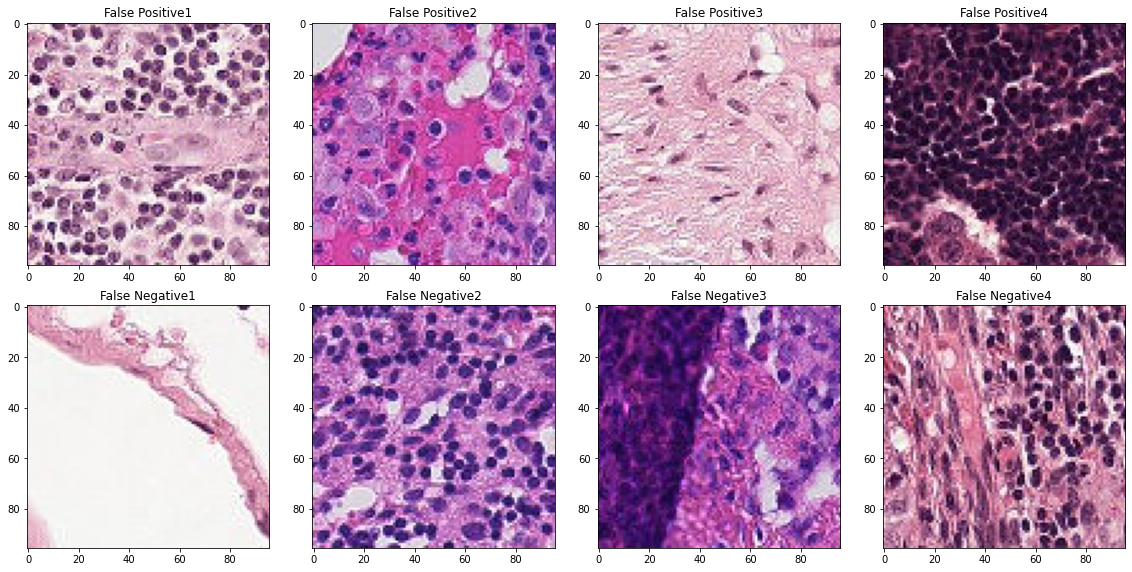

In [48]:
# Let's plot 4 false positives and 4 false negatives
False_pos  = ['f04af7f0929e70aecd4de07f3c22f683160fede7.tif', '68d9005d7e9d0799c0099eec3a902b6d007b50f9.tif', '1092801a1d1d7cc8e45b1d909c553ea400615d68.tif', '1048f0c12198635d8b2db25f233be11e8942a80a.tif'   ]
False_neg = ['b11d38879a191ae46e5faa3bc38280a1c353fff3.tif', '0e3676c7d2df7b6e1dab47a3d63061c845e2895f.tif', '9d3b41f478029bb31707fe8048dea27fc4c980fc.tif', '240b3973e336e4b082f2d5a28574dc6b1bd671be.tif' ]
r=1
plt.figure(figsize = (16,8))
for fp in False_pos:
    im = plt.imread('Original Data\\train\\' + fp)
    plt.subplot(2,4,r)
    plt.title('False Positive'+ str(r))
    plt.imshow(im)
    r+=1

for fn in False_neg:
    im = plt.imread('Original Data\\train\\' + fn)
    plt.subplot(2,4,r)
    plt.title('False Negative'+str(r-4))
    plt.imshow(im)
    r+= 1
plt.tight_layout()
plt.show()

## What Do the convNETS learn ?

In [63]:
# install keras-vis package
pip install https://github.com/raghakot/keras-vis/archive/master.zip

  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30861 sha256=c144fad776a97fa0d0c8b1cc81ecb23c22d5c07cf1f963302f38575310cb11a3
  Stored in directory: C:\Users\Gianluca\AppData\Local\Temp\pip-ephem-wheel-cache-20a94g73\wheels\86\18\04\ffe2ca1aa9fedc1e1b11a85372ad6c5ba2b4f25592d704737b
Successfully built keras-vis
Note: you may need to restart the kernel to use updated packages.


In [69]:
from vis.visualization import visualize_activation, get_num_filters
from vis.input_modifiers import Jitter
from vis.utils import utils

**Pick the best model among the 5 KF models**

In [54]:
test_data['KF1_VERSION_2_average'] = np.mean(test_data[['pred_KF1_VERSION_2_AUG1', 'pred_KF1_VERSION_2_AUG2', 'pred_KF1_VERSION_2_AUG3', 'pred_KF1_VERSION_2_AUG4', 'pred_KF1_VERSION_2_AUG5']], axis = 1)
test_data['KF2_VERSION_2_average'] = np.mean(test_data[['pred_KF2_VERSION_2_AUG1', 'pred_KF2_VERSION_2_AUG2', 'pred_KF2_VERSION_2_AUG3', 'pred_KF2_VERSION_2_AUG4', 'pred_KF2_VERSION_2_AUG5']], axis = 1)
test_data['KF3_VERSION_2_average'] = np.mean(test_data[['pred_KF3_VERSION_2_AUG1', 'pred_KF3_VERSION_2_AUG2', 'pred_KF3_VERSION_2_AUG3', 'pred_KF3_VERSION_2_AUG4', 'pred_KF3_VERSION_2_AUG5']], axis = 1)
test_data['KF4_VERSION_2_average'] = np.mean(test_data[['pred_KF4_VERSION_2_AUG1', 'pred_KF4_VERSION_2_AUG2', 'pred_KF4_VERSION_2_AUG3', 'pred_KF4_VERSION_2_AUG4', 'pred_KF4_VERSION_2_AUG5']], axis = 1)
test_data['KF5_VERSION_2_average'] = np.mean(test_data[['pred_KF5_VERSION_2_AUG1', 'pred_KF5_VERSION_2_AUG2', 'pred_KF5_VERSION_2_AUG3', 'pred_KF5_VERSION_2_AUG4', 'pred_KF5_VERSION_2_AUG5']], axis = 1)

In [55]:
for i in range(1,6):
    print('AUC for Fold', i, 'is')
    print(roc_auc_score(test_data['label'], test_data['KF'+str(i)+'_VERSION_2_average']))

AUC for Fold 1 is
0.9971291759438655
AUC for Fold 2 is
0.997425460698258
AUC for Fold 3 is
0.9974409477881089
AUC for Fold 4 is
0.9973250350705554
AUC for Fold 5 is
0.9975517694281042


**Import the model relative to KF5**

In [57]:
with open('Model_K_fold_5_VERSION 2.json', 'r') as mod_j:
    mod = mod_j.read()
    
MODEL = model_from_json(mod)
MODEL.load_weights('Model_K_fold_5_VERSION 2.h5')
MODEL.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 96, 96, 128)       3584      
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 96, 96, 128)       147584    
_________________________________________________________________
batch_normalization_29 (Batc (None, 96, 96, 128)       512       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
batch_normalization_30 (Batc (None, 48, 48, 128)      

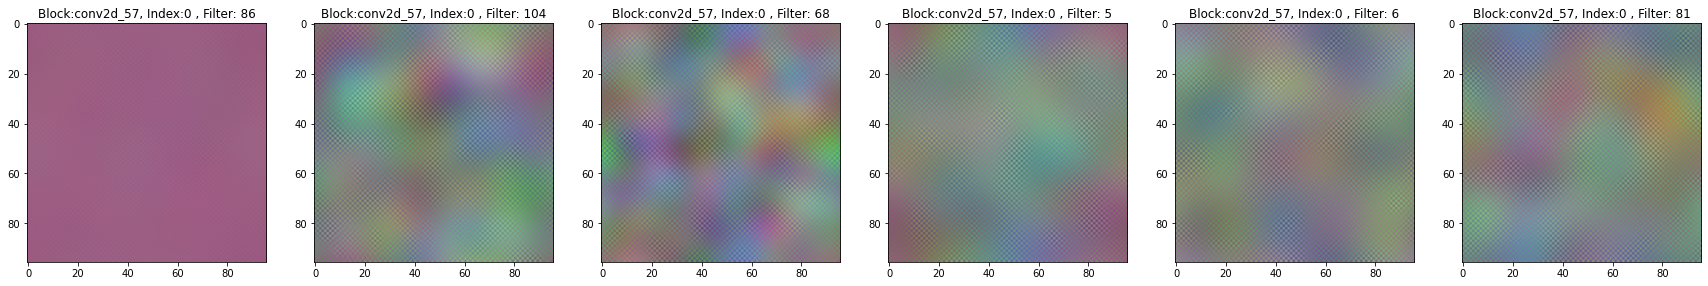

In [126]:

block = 'conv2d_57'
index = utils.find_layer_idx(MODEL, block)
n = 6
plt.figure(figsize =(30,6))
fig = 1
for i in np.random.randint(0,128, n):
    img = visualize_activation(model, layer_idx = index, filter_indices = i, input_modifiers=[Jitter(10)])
    plt.subplot(1,n,fig)
    plt.title('Block:'+block+', Index:'+str(index)+' , Filter: '+ str(i))
    plt.imshow(img)
    fig+=1
plt.show()

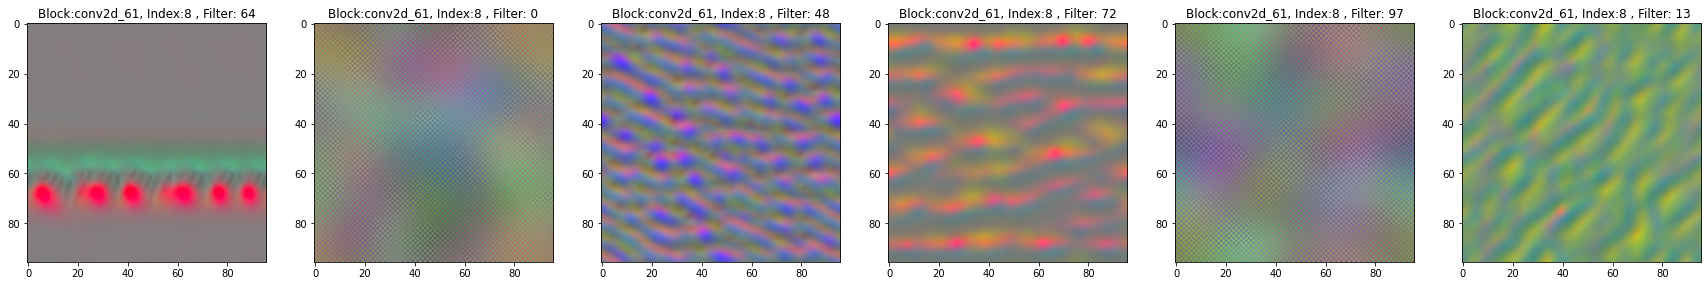

In [129]:

block = 'conv2d_61'
index = utils.find_layer_idx(MODEL, block)
n = 6
plt.figure(figsize =(30,6))
fig = 1
for i in np.random.randint(0,128, n):
    img = visualize_activation(model, layer_idx = index, filter_indices = i, input_modifiers=[Jitter(10)])
    plt.subplot(1,n,fig)
    plt.title('Block:'+block+', Index:'+str(index)+' , Filter: '+ str(i))
    plt.imshow(img)
    fig+=1
plt.show()

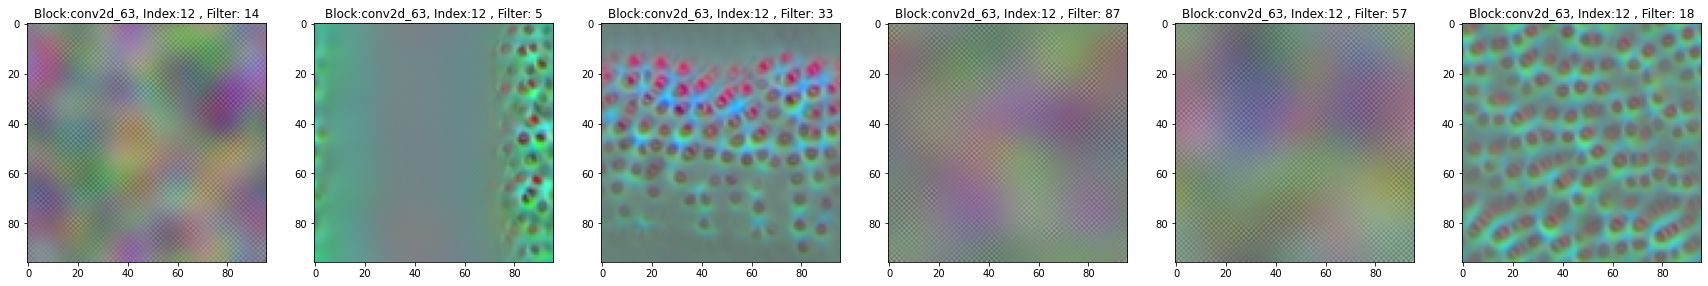

In [128]:

block = 'conv2d_63'
index = utils.find_layer_idx(MODEL, block)
n = 6
plt.figure(figsize =(30,6))
fig = 1
for i in np.random.randint(0,96, n):
    img = visualize_activation(model, layer_idx = index, filter_indices = i, input_modifiers=[Jitter(5)])
    plt.subplot(1,n,fig)
    plt.title('Block:'+block+', Index:'+str(index)+' , Filter: '+ str(i))
    plt.imshow(img)
    fig+=1
plt.show()